# Part 2

### Dataset Loading and Initial Setup

We began the analysis by importing the required Python libraries for data handling, visualization, and preprocessing. 
The dataset `M25_DA_A1_Dataset2.csv` was then loaded into a Pandas DataFrame.


In [136]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

In [137]:
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
csv_file = "/kaggle/input/m25-da-a1-dataset2/M25_DA_A1_Dataset2.csv"
df = pd.read_csv(csv_file, low_memory=False)

# print("Dataset Shape:", df.shape)
# print("\nColumn Names:")
# print(df.columns.tolist())
# print("\nFirst 3 rows:")
df.head(3)

,ID,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Approved Authority Name,Units Available,Price,Price (English),...,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,Possession By,NRI Pref,Land Area / Covered Area,Land Area Unit,Pantry Type
0,12685,Under Construction,Dec '25,5,N,NaN,KDMC,1.0,3150000.0,31.5 Lac,...,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN
1,12684,Ready to Move,NaN,20,Y,TATA Housing Development Company Ltd.,TMC,10.0,6300000.0,63 Lac,...,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN
2,12683,Ready to Move,NaN,18,N,Sai Satyam Developers,KDMC,0.0,5400000.0,54 Lac,...,1,1,1,1,1,NaN,Y,NaN,NaN,NaN


### Data Cleaning - remove columns with high missing values

We removed columns with more than 80% missing values to reduce noise and improve dataset quality.


In [138]:
# Data Cleaning - remove columns with high missing values
miss_threshold = 0.8  # 80% missing data threshold
miss_percentage = df.isnull().mean()

print("Missing value percentages for all columns:")
for col in miss_percentage.index:
    if miss_percentage[col] > 0:
        print(f"{col}: {miss_percentage[col]:.2%}")

# Find columns to drop
dropping_cols = miss_percentage[miss_percentage > miss_threshold].index
print(f"\nColumns to drop (>{miss_threshold:.0%} missing): {len(dropping_cols)}")
print(dropping_cols.tolist())

# Drop high missing value columns
cleaned_df = df.drop(columns=dropping_cols)
print(f"\nDataset shape after dropping high missing columns: {cleaned_df.shape}")

Missing value percentages for all columns:
Possession Status: 0.61%
Availability Starts From: 75.70%
Floor No: 6.76%
Developer: 44.77%
Approved Authority Name: 51.57%
Units Available: 51.64%
Price: 0.66%
Flooring Type: 35.74%
Electricity Status: 42.77%
Maintenance Type: 44.25%
Maintenance Charges: 50.47%
Booking Amount: 39.29%
Landmark: 36.61%
Covered Area: 10.34%
Project Name: 35.72%
sqft Price : 9.50%
Carpet Area: 20.12%
Property Uniqueness: 63.26%
Unit of Carpet Area: 10.30%
Ownership Type: 25.70%
furnished Type: 0.61%
Bathroom: 0.54%
Parking: 48.55%
Facing: 28.14%
Amenities Facing: 32.31%
Floor Data: 6.76%
floors: 6.83%
Water Status: 42.54%
Covered Area.1: 10.34%
Carpet Area Unit: 20.55%
Location: 2.55%
Property: 2.55%
covArea Unit: 10.30%
Property Lifespan: 37.93%
balconies: 54.58%
Rera: 81.28%
Possession By: 98.14%
NRI Pref: 84.10%
Land Area / Covered Area: 99.34%
Land Area Unit: 99.32%
Pantry Type: 99.49%

Columns to drop (>80% missing): 6
['Rera', 'Possession By', 'NRI Pref', '

### Drop unnecessary columns

We dropped redundant columns (e.g., ID, duplicate price fields) and cleaned the Price column by converting it to numeric and imputing missing values with city-wise averages.


In [139]:
# Drop unnecessary columns
columns_to_drop = ['Price (English)', 'Carpet Area Unit', 'ID']
# Only drop columns that exist in the dataset
columns_to_drop = [col for col in columns_to_drop if col in cleaned_df.columns]
cleaned_df = cleaned_df.drop(columns=columns_to_drop)

print(f"Columns dropped: {columns_to_drop}")
print(f"Dataset shape after dropping unnecessary columns: {cleaned_df.shape}")

# Clean Price column
print("\nCleaning Price column...")
print(f"Price column before cleaning - data type: {cleaned_df['Price'].dtype}")
print(f"Sample price values: {cleaned_df['Price'].head()}")

# Remove special characters from 'Price' and convert to float
cleaned_df['Price'] = pd.to_numeric(cleaned_df['Price'], errors='coerce')

# Fill missing values in 'Price' with the mean price for each city
cleaned_df['Price'].fillna(cleaned_df.groupby('City')['Price'].transform('mean'), inplace=True)

print(f"Price column after cleaning - data type: {cleaned_df['Price'].dtype}")
print(f"Missing values in Price: {cleaned_df['Price'].isnull().sum()}")

Columns dropped: ['Price (English)', 'Carpet Area Unit', 'ID']
Dataset shape after dropping unnecessary columns: (12685, 136)

Cleaning Price column...
Price column before cleaning - data type: float64
Sample price values: 0    3150000.0
1    6300000.0
2    5400000.0
3    9000000.0
4    4950000.0
Name: Price, dtype: float64
Price column after cleaning - data type: float64
Missing values in Price: 0


### Clean Carpet Area

We standardized numerical features such as Carpet Area and Floor details, handling special cases (e.g., Ground floor) and extracting structured floor information.


In [140]:
# Clean Carpet Area
if 'Carpet Area' in cleaned_df.columns:
    print("Cleaning Carpet Area column...")
    # Convert to numeric, removing any non-numeric characters
    cleaned_df['Carpet Area'] = pd.to_numeric(cleaned_df['Carpet Area'], errors='coerce')
    # Fill missing values with mean by city
    cleaned_df['Carpet Area'].fillna(cleaned_df.groupby('City')['Carpet Area'].transform('mean'), inplace=True)

# Clean Floor No
if 'Floor No' in cleaned_df.columns:
    print("Cleaning Floor No column...")
    # Replace 'Ground' with 0, handle other special cases
    cleaned_df['Floor No'] = cleaned_df['Floor No'].replace({
        'Ground': 0,
        'Upper Basement': 100,
        'Lower Basement': -1
    })
    cleaned_df['Floor No'] = pd.to_numeric(cleaned_df['Floor No'], errors='coerce')

# Extract current and total floors from 'Floor Data'
if 'Floor Data' in cleaned_df.columns:
    print("Extracting floor information from Floor Data...")
    cleaned_df['Current Floor'] = cleaned_df['Floor Data'].str.extract(r'(\d+) of \d+ Floor').astype(float)
    cleaned_df['Total Floors'] = cleaned_df['Floor Data'].str.extract(r'\d+ of (\d+) Floor').astype(float)
    cleaned_df = cleaned_df.drop('Floor Data', axis=1)

print(f"Dataset shape after cleaning numeric columns: {cleaned_df.shape}")

Cleaning Carpet Area column...
Cleaning Floor No column...
Extracting floor information from Floor Data...
Dataset shape after cleaning numeric columns: (12685, 137)


### Convert categorical columns

We converted categorical fields (e.g., City, Property Type) into category dtype and transformed the 'Availability Starts From' column into datetime format for time-based analysis.


In [141]:
# Convert categorical columns
categorical_cols = ['Possession Status', 'Type of Property', 'City', 'furnished Type']
for col in categorical_cols:
    if col in cleaned_df.columns:
        cleaned_df[col] = cleaned_df[col].astype('category')
        print(f"Converted {col} to category - unique values: {cleaned_df[col].nunique()}")

# Convert 'Availability Starts From' to datetime
if 'Availability Starts From' in cleaned_df.columns:
    print("Converting Availability Starts From to datetime...")
    cleaned_df['Availability Starts From'] = pd.to_datetime(
        cleaned_df['Availability Starts From'], 
        format="%b '%y", 
        errors='coerce'
    )

print(f"\nFinal dataset shape: {cleaned_df.shape}")

Converted Possession Status to category - unique values: 21
Converted Type of Property to category - unique values: 5
Converted City to category - unique values: 9
Converted furnished Type to category - unique values: 3
Converting Availability Starts From to datetime...

Final dataset shape: (12685, 137)


### Check remaining missing values

We finalized the cleaned dataset, checked remaining missing values, and summarized key statistics for Price and city distributions.


In [142]:
# Check remaining missing values
print("=== FINAL DATA CLEANING SUMMARY ===")
print(f"Final dataset shape: {cleaned_df.shape}")

remaining_missing = cleaned_df.isnull().sum()
print(f"\nColumns with missing values:")
for col in remaining_missing[remaining_missing > 0].index:
    percentage = remaining_missing[col] / len(cleaned_df) * 100
    print(f"{col}: {remaining_missing[col]} ({percentage:.1f}%)")

# Final DataFrame
final_df = cleaned_df.copy()

print(f"\nPrice statistics:")
print(f"Min Price: ₹{final_df['Price'].min():,.0f}")
print(f"Max Price: ₹{final_df['Price'].max():,.0f}")
print(f"Mean Price: ₹{final_df['Price'].mean():,.0f}")
print(f"Median Price: ₹{final_df['Price'].median():,.0f}")

print(f"\nTop cities by property count:")
print(final_df['City'].value_counts().head())

print("\nData cleaning completed successfully!")

=== FINAL DATA CLEANING SUMMARY ===
Final dataset shape: (12685, 137)

Columns with missing values:
Possession Status: 78 (0.6%)
Availability Starts From: 9602 (75.7%)
Floor No: 858 (6.8%)
Developer: 5679 (44.8%)
Approved Authority Name: 6542 (51.6%)
Units Available: 6550 (51.6%)
Flooring Type: 4534 (35.7%)
Electricity Status: 5425 (42.8%)
Maintenance Type: 5613 (44.2%)
Maintenance Charges: 6402 (50.5%)
Booking Amount: 4984 (39.3%)
Landmark: 4644 (36.6%)
Covered Area: 1311 (10.3%)
Project Name: 4531 (35.7%)
sqft Price : 1205 (9.5%)
Carpet Area: 3 (0.0%)
Property Uniqueness: 8025 (63.3%)
Unit of Carpet Area: 1307 (10.3%)
Ownership Type: 3260 (25.7%)
furnished Type: 77 (0.6%)
Bathroom: 69 (0.5%)
Parking: 6159 (48.6%)
Facing: 3569 (28.1%)
Amenities Facing: 4099 (32.3%)
floors: 866 (6.8%)
Water Status: 5396 (42.5%)
Covered Area.1: 1311 (10.3%)
Location: 323 (2.5%)
Property: 323 (2.5%)
covArea Unit: 1307 (10.3%)
Property Lifespan: 4812 (37.9%)
balconies: 6923 (54.6%)
Current Floor: 1441 (11

## Question 1

#### 1. Price Segmentation & Market Overview [7.5 Marks]
Divide the properties into three price ranges and analyse their distribution across cities.

##### Define price labels for categories

### Price Segmentation Using Quantiles
We divided properties into three price categories (Low, Medium, High Budget) using 33rd and 67th percentiles of price. This ensures a balanced segmentation of properties across the three ranges.


In [143]:
# Define price labels for categories
price_labels = ["Low Budget", "Medium Budget", "High Budget"]

# Calculate the quantiles for price categorization
quantiles = final_df["Price"].quantile([1/3, 2/3]).values
print("Price Quantiles:")
print(f"33rd percentile: ₹{quantiles[0]:,.0f} ({quantiles[0]/100000:.1f} Lac)")
print(f"67th percentile: ₹{quantiles[1]:,.0f} ({quantiles[1]/100000:.1f} Lac)")

# Function to categorize the price range based on quantiles
def price_range(price):
    """Categorize price into budget ranges."""
    if price <= quantiles[0]:
        return price_labels[0]
    elif quantiles[0] < price <= quantiles[1]:
        return price_labels[1]
    return price_labels[2]

# Apply the price_range function to create a new column "Price Category"
final_df["Price Category"] = final_df["Price"].apply(price_range)

# Display the distribution
print("\nPrice Category Distribution:")
price_dist = final_df["Price Category"].value_counts()
for category, count in price_dist.items():
    percentage = count/len(final_df)*100
    print(f"{category}: {count} properties ({percentage:.1f}%)")

Price Quantiles:
33rd percentile: ₹8,900,000 (89.0 Lac)
67th percentile: ₹20,000,000 (200.0 Lac)

Price Category Distribution:
Medium Budget: 4311 properties (34.0%)
Low Budget: 4236 properties (33.4%)
High Budget: 4138 properties (32.6%)


### Visualization Functions for Price Distribution Across Cities
We created reusable functions (pie chart, bar charts, scatter plot) to analyze the distribution of price categories across cities. These visualizations help compare absolute numbers, percentages, and overall trends in property prices across different locations.


In [144]:
# Create a distribution DataFrame for plotting
distribution = final_df.groupby(["City", "Price Category"]).size().unstack(fill_value=0)
print("\nCity-wise Price Category Distribution:")
print(distribution)

# Calculate percentages
distribution_pct = final_df.groupby(["City", "Price Category"]).size().unstack(fill_value=0)
distribution_pct = distribution_pct.div(distribution_pct.sum(axis=1), axis=0) * 100
print("\nCity-wise Price Category Distribution (Percentages):")
print(distribution_pct.round(1))


City-wise Price Category Distribution:
Price Category  High Budget  Low Budget  Medium Budget
City                                                  
Agartala                  0           1              0
Bhiwandi                  0           2              0
Gurgaon                   0           1              0
Hyderabad                 0           8              0
Kalyan                    0           7              2
Mumbai                 3774        2085           2683
Nagpur                    0           5              2
Palghar                   0           2              0
Thane                   364        2125           1624

City-wise Price Category Distribution (Percentages):
Price Category  High Budget  Low Budget  Medium Budget
City                                                  
Agartala                0.0       100.0            0.0
Bhiwandi                0.0       100.0            0.0
Gurgaon                 0.0       100.0            0.0
Hyderabad               0.

### Plots

### Executing Price Distribution Analysis
We applied the segmentation and generated multiple plots:
- Pie charts for city-wise category distribution
- Bar charts (stacked, grouped, percentage) for city-level comparisons
- Scatter plots of price vs. city on a log scale

Additionally, we produced summary statistics for each budget segment, including property counts, price ranges, average price, and top contributing cities.


In [145]:
def plot_pie(distribution):
    """Plot pie charts for price distribution across cities."""
    cities = distribution.index
    n_cities = len(cities)
    
    # Create subplot for pie charts
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Price Category Distribution by City', fontsize=16, fontweight='bold')
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for i, city in enumerate(cities[:6]):  # Show top 6 cities
        row = i // 3
        col = i % 3
        
        city_data = distribution.loc[city]
        city_data = city_data[city_data > 0]  # Remove zero values
        
        axes[row, col].pie(city_data.values, labels=city_data.index, autopct='%1.1f%%', 
                          colors=colors, startangle=90)
        axes[row, col].set_title(f'{city}\n({distribution.loc[city].sum()} properties)', 
                               fontweight='bold')
    
    # Remove empty subplots
    for i in range(len(cities), 6):
        row = i // 3
        col = i % 3
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()

def plot_bar(distribution):
    """Plot bar charts for price distribution across cities."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Price Category Distribution Analysis', fontsize=16, fontweight='bold')
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # 1. Stacked bar chart
    axes[0, 0].set_title('Stacked Bar Chart - Absolute Numbers')
    distribution.plot(kind='bar', stacked=True, ax=axes[0, 0], color=colors)
    axes[0, 0].set_xlabel('City')
    axes[0, 0].set_ylabel('Number of Properties')
    axes[0, 0].legend(title='Price Category')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Grouped bar chart
    axes[0, 1].set_title('Grouped Bar Chart - Absolute Numbers')
    distribution.plot(kind='bar', ax=axes[0, 1], color=colors)
    axes[0, 1].set_xlabel('City')
    axes[0, 1].set_ylabel('Number of Properties')
    axes[0, 1].legend(title='Price Category')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Percentage stacked bar chart
    axes[1, 0].set_title('Percentage Distribution by City')
    distribution_pct = distribution.div(distribution.sum(axis=1), axis=0) * 100
    distribution_pct.plot(kind='bar', stacked=True, ax=axes[1, 0], color=colors)
    axes[1, 0].set_xlabel('City')
    axes[1, 0].set_ylabel('Percentage of Properties')
    axes[1, 0].legend(title='Price Category')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Total properties by city
    axes[1, 1].set_title('Total Properties by City')
    city_totals = distribution.sum(axis=1).sort_values(ascending=False)
    axes[1, 1].bar(city_totals.index, city_totals.values, color='lightcoral')
    axes[1, 1].set_xlabel('City')
    axes[1, 1].set_ylabel('Total Properties')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(city_totals.values):
        axes[1, 1].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_scatter(final_df):
    """Plot scatter plot for city vs. log-log of price."""
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot with different colors for different price categories
    colors = {'Low Budget': '#FF6B6B', 'Medium Budget': '#4ECDC4', 'High Budget': '#45B7D1'}
    
    for category in price_labels:
        category_data = final_df[final_df['Price Category'] == category]
        plt.scatter(category_data['City'], np.log10(category_data['Price']), 
                   label=category, color=colors[category], alpha=0.6, s=50)
    
    plt.xlabel('City', fontweight='bold')
    plt.ylabel('Log10(Price)', fontweight='bold')
    plt.title('Price Distribution Across Cities (Log Scale)', fontsize=14, fontweight='bold')
    plt.legend(title='Price Category')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

=== PRICE SEGMENTATION & MARKET OVERVIEW ANALYSIS ===
Price Quantiles:
33rd percentile: ₹8,900,000 (89.0 Lac)
67th percentile: ₹20,000,000 (200.0 Lac)


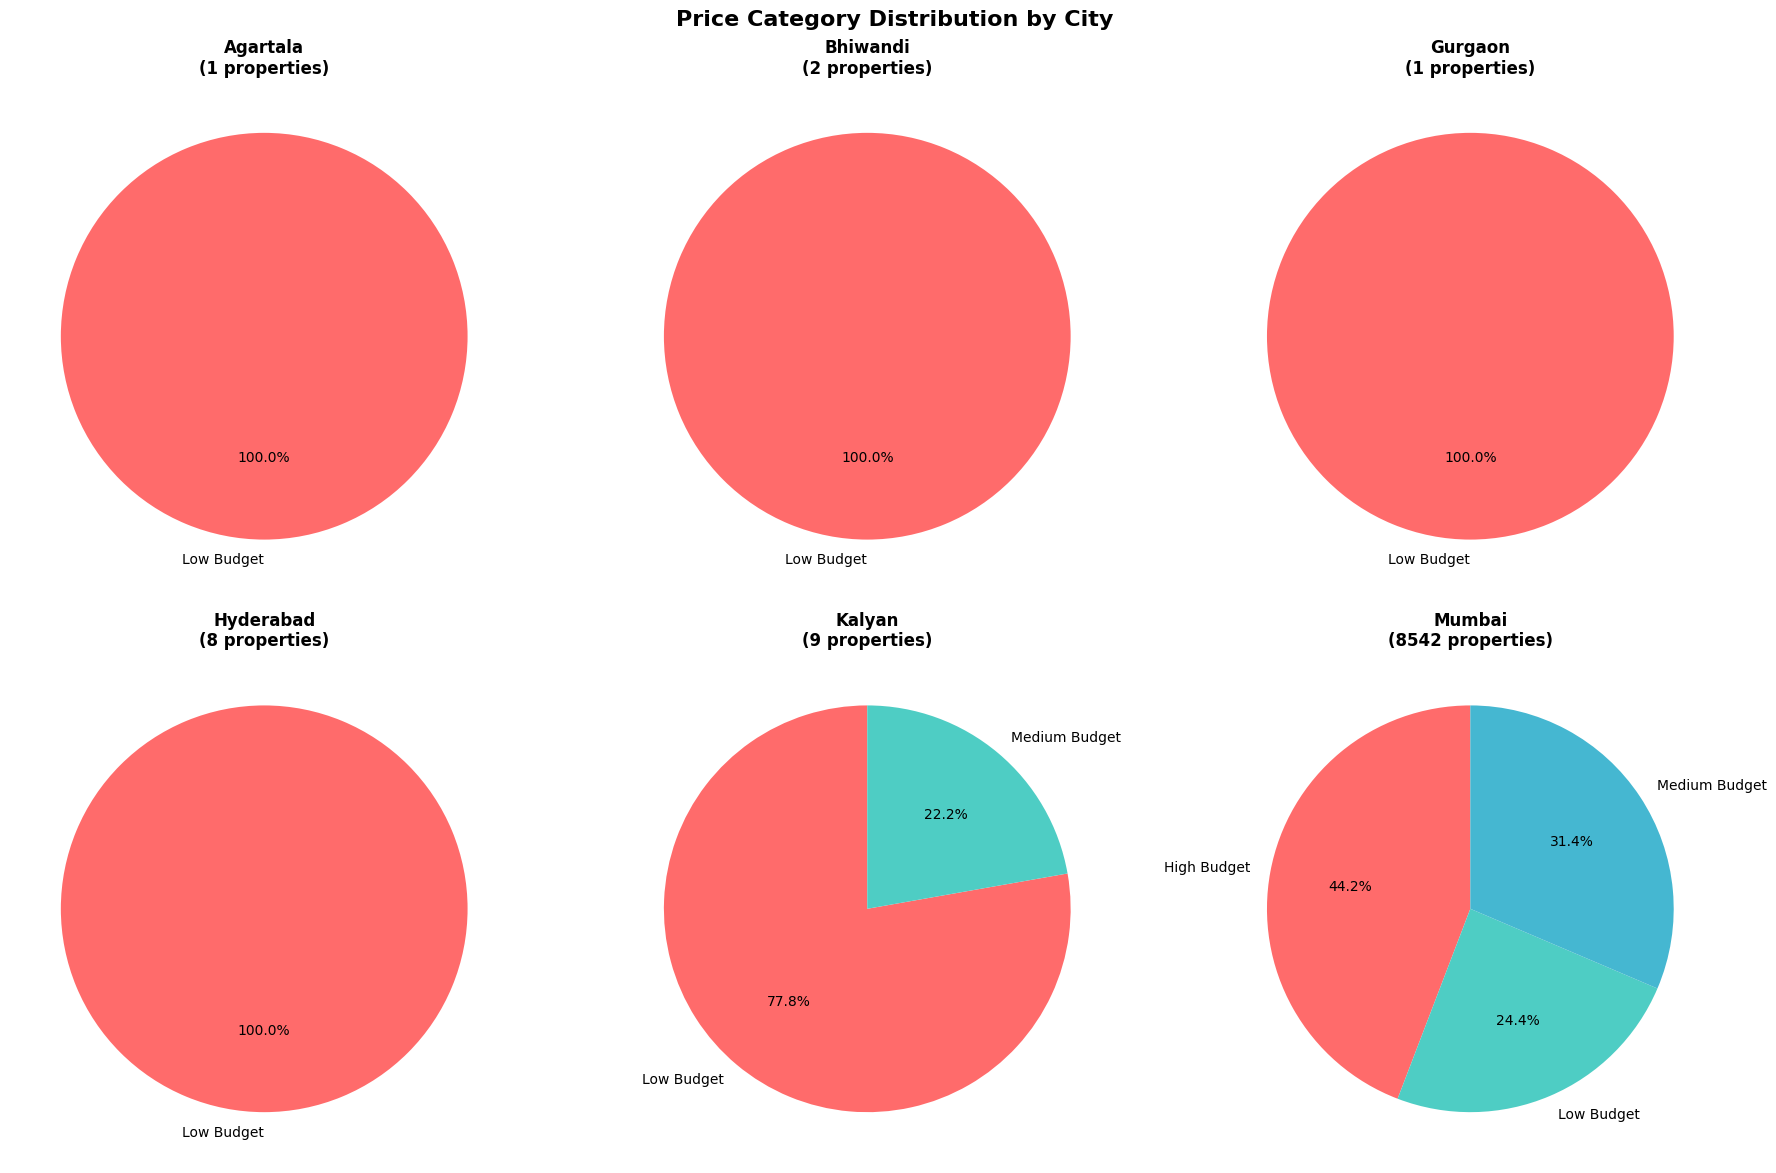

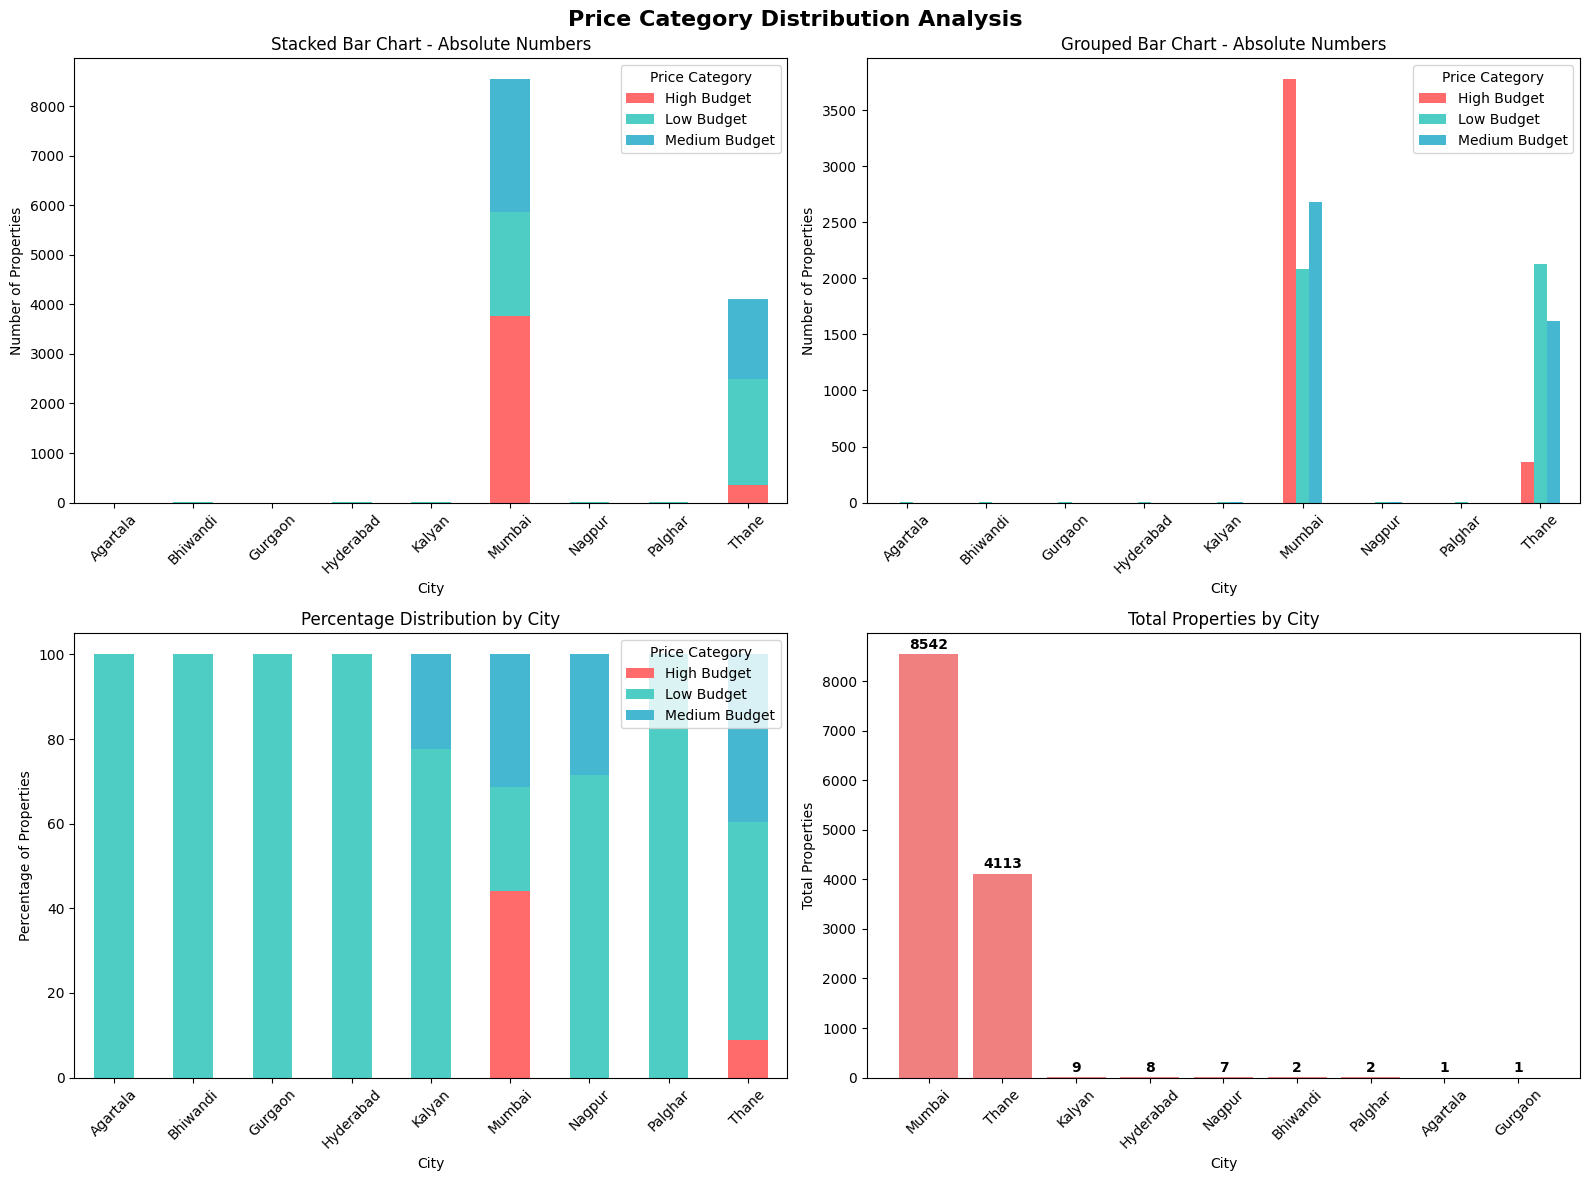

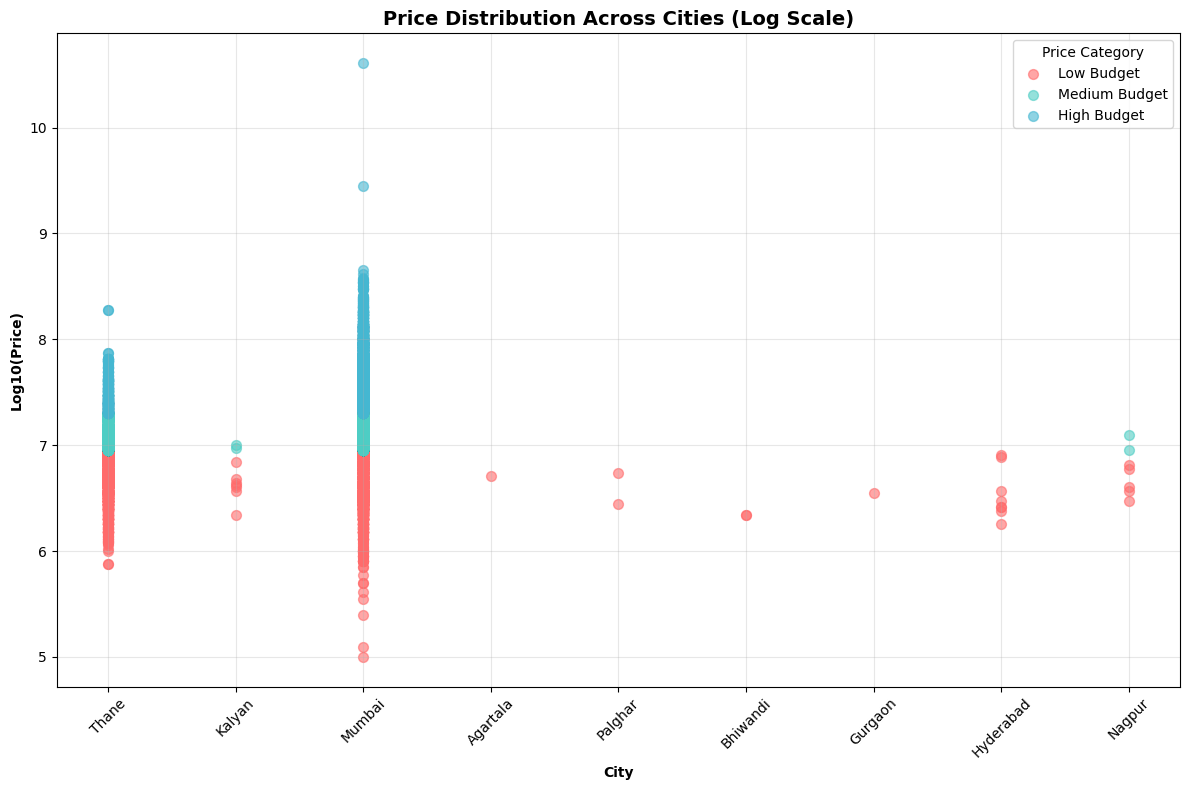


=== SUMMARY STATISTICS ===

Low Budget:
  Count: 4236 properties
  Price range: ₹1.0L - ₹89.0L
  Average price: ₹52.2L
  Top cities: {'Thane': 2125, 'Mumbai': 2085, 'Hyderabad': 8}

Medium Budget:
  Count: 4311 properties
  Price range: ₹89.5L - ₹200.0L
  Average price: ₹139.1L
  Top cities: {'Mumbai': 2683, 'Thane': 1624, 'Kalyan': 2}

High Budget:
  Count: 4138 properties
  Price range: ₹200.0L - ₹408000.0L
  Average price: ₹610.5L
  Top cities: {'Mumbai': 3774, 'Thane': 364, 'Agartala': 0}


In [146]:
# Execute all visualizations
print("=== PRICE SEGMENTATION & MARKET OVERVIEW ANALYSIS ===")

# Show quantiles
quantiles = final_df["Price"].quantile([1/3, 2/3]).values
print("Price Quantiles:")
print(f"33rd percentile: ₹{quantiles[0]:,.0f} ({quantiles[0]/100000:.1f} Lac)")
print(f"67th percentile: ₹{quantiles[1]:,.0f} ({quantiles[1]/100000:.1f} Lac)")

# Function to categorize price
def price_range(price):
    if price <= quantiles[0]:
        return "Low Budget"
    elif quantiles[0] < price <= quantiles[1]:
        return "Medium Budget"
    return "High Budget"

# Apply categorization
final_df["Price Category"] = final_df["Price"].apply(price_range)

# Create distribution matrix
distribution = final_df.groupby(["City", "Price Category"]).size().unstack(fill_value=0)

# Generate all plots
plot_pie(distribution)
plot_bar(distribution)
plot_scatter(final_df)

# Summary statistics
print("\n=== SUMMARY STATISTICS ===")
for category in ["Low Budget", "Medium Budget", "High Budget"]:
    cat_data = final_df[final_df["Price Category"] == category]
    print(f"\n{category}:")
    print(f"  Count: {len(cat_data)} properties")
    print(f"  Price range: ₹{cat_data['Price'].min()/100000:.1f}L - ₹{cat_data['Price'].max()/100000:.1f}L")
    print(f"  Average price: ₹{cat_data['Price'].mean()/100000:.1f}L")
    print(f"  Top cities: {cat_data['City'].value_counts().head(3).to_dict()}")

#### Provide a high-level market summary for each price range, incorporating property type, city, and keyamenities to give investors a quick snapshot of the market.

### Alternative Price Categorization and Validation
As a validation step, we re-created the price categories using quantiles and displayed the overall distribution. This confirmed consistency in segmentation and ensured no missing or invalid values in the price column.


In [147]:
final_df = df.dropna(subset=['Price']).copy()

# Define price labels for categories
price_labels = ["Low Budget", "Medium Budget", "High Budget"]

# Calculate the quantiles for price categorization
quantiles = final_df["Price"].quantile([1/3, 2/3]).values
print("Price Quantiles:")
print(f"33rd percentile: ₹{quantiles[0]:,.0f} ({quantiles[0]/100000:.1f} Lac)")
print(f"67th percentile: ₹{quantiles[1]:,.0f} ({quantiles[1]/100000:.1f} Lac)")

# Function to categorize the price range based on quantiles
def price_range(price):
    """Categorize price into budget ranges."""
    if price <= quantiles[0]:
        return price_labels[0]
    elif quantiles[0] < price <= quantiles[1]:
        return price_labels[1]
    return price_labels[2]

# Apply the price_range function to create a new column "Price Category"
final_df["Price Category"] = final_df["Price"].apply(price_range)

print("\nPrice Category Distribution:")
price_dist = final_df["Price Category"].value_counts()
for category, count in price_dist.items():
    percentage = count/len(final_df)*100
    print(f"{category}: {count} properties ({percentage:.1f}%)")

Price Quantiles:
33rd percentile: ₹8,800,000 (88.0 Lac)
67th percentile: ₹20,000,000 (200.0 Lac)

Price Category Distribution:
Medium Budget: 4306 properties (34.2%)
Low Budget: 4204 properties (33.4%)
High Budget: 4091 properties (32.5%)


### Amenity Feature Engineering
We identified key amenities (Swimming Pool, Gymnasium, Club House, Parking, Security, Lift) and created binary columns to capture their presence in each property. This step enables us to compare amenity availability across different price categories and cities.


In [148]:
# Define amenities to check in the dataset based on what's available
amenities = ["Swimming Pool", "Gymnasium", "Club House", "Parking", "Security", "Lift"]

# Fill missing values and create binary columns indicating the presence of each amenity
for amenity in amenities:
    if amenity in final_df.columns:
        final_df[amenity] = final_df[amenity].fillna(0)  # Fill missing values with 0
        final_df[f"Has {amenity}"] = final_df[amenity].apply(
            lambda x: 1 if x != 0 and x != "" and str(x).lower() != 'nan' else 0
        )  # Create binary column for presence of each amenity
    else:
        print(f"Warning: {amenity} column not found in dataset")
        final_df[f"Has {amenity}"] = 0  # Create dummy column with all zeros

print("Amenity columns created successfully!")

Amenity columns created successfully!


#### Create comprehensive market summary for each price range

In [149]:
# Create comprehensive market summary for each price range
market_summary = {}

for category in price_labels:
    category_data = final_df[final_df["Price Category"] == category].copy()
    
    summary = {
        'total_properties': len(category_data),
        'price_range': f"₹{category_data['Price'].min()/100000:.1f}L - ₹{category_data['Price'].max()/100000:.1f}L",
        'avg_price': f"₹{category_data['Price'].mean()/100000:.1f}L",
        'top_cities': category_data['City'].value_counts().head(3).to_dict(),
        'property_types': category_data['Type of Property'].value_counts().head(3).to_dict(),
        'amenities_availability': {}
    }
    
    # Calculate amenity availability percentages
    for amenity in amenities:
        if f"Has {amenity}" in category_data.columns:
            availability = category_data[f"Has {amenity}"].mean() * 100
            summary['amenities_availability'][amenity] = f"{availability:.1f}%"
    
    market_summary[category] = summary

# Display market summary
for category, summary in market_summary.items():
    print(f"\n{'='*50}")
    print(f"{category.upper()} SEGMENT MARKET SUMMARY")
    print(f"{'='*50}")
    print(f"Total Properties: {summary['total_properties']:,}")
    print(f"Price Range: {summary['price_range']}")
    print(f"Average Price: {summary['avg_price']}")
    print(f"\nTop Cities:")
    for city, count in summary['top_cities'].items():
        print(f"  • {city}: {count:,} properties")
    print(f"\nTop Property Types:")
    for prop_type, count in summary['property_types'].items():
        print(f"  • {prop_type}: {count:,} properties")
    print(f"\nKey Amenities Availability:")
    for amenity, percentage in summary['amenities_availability'].items():
        print(f"  • {amenity}: {percentage}")


LOW BUDGET SEGMENT MARKET SUMMARY
Total Properties: 4,204
Price Range: ₹1.0L - ₹88.0L
Average Price: ₹51.9L

Top Cities:
  • Thane: 2,114 properties
  • Mumbai: 2,064 properties
  • Hyderabad: 8 properties

Top Property Types:
  • Apartment: 3,916 properties
  • Builder Floor Apartment: 145 properties
  • Residential House: 127 properties

Key Amenities Availability:
  • Swimming Pool: 46.5%
  • Gymnasium: 48.7%
  • Club House: 48.5%
  • Parking: 35.9%
  • Security: 60.6%
  • Lift: 60.9%

MEDIUM BUDGET SEGMENT MARKET SUMMARY
Total Properties: 4,306
Price Range: ₹88.1L - ₹200.0L
Average Price: ₹139.0L

Top Cities:
  • Mumbai: 2,704 properties
  • Thane: 1,598 properties
  • Kalyan: 2 properties

Top Property Types:
  • Apartment: 4,195 properties
  • Residential House: 57 properties
  • Builder Floor Apartment: 38 properties

Key Amenities Availability:
  • Swimming Pool: 58.8%
  • Gymnasium: 61.5%
  • Club House: 60.0%
  • Parking: 49.1%
  • Security: 71.7%
  • Lift: 73.8%

HIGH BUDGE

### Market Summary by Price Category
We compiled a comprehensive market summary for each price range, reporting:
- Total properties, price range, and average price
- Top cities and property types
- Percentage availability of key amenities

This provides investors a clear overview of market characteristics in each price segment.


### Property Type Distribution Across All Cities
We plotted a donut chart showing the percentage share of property types across the dataset. This helps visualize whether residential or commercial properties dominate different market segments.


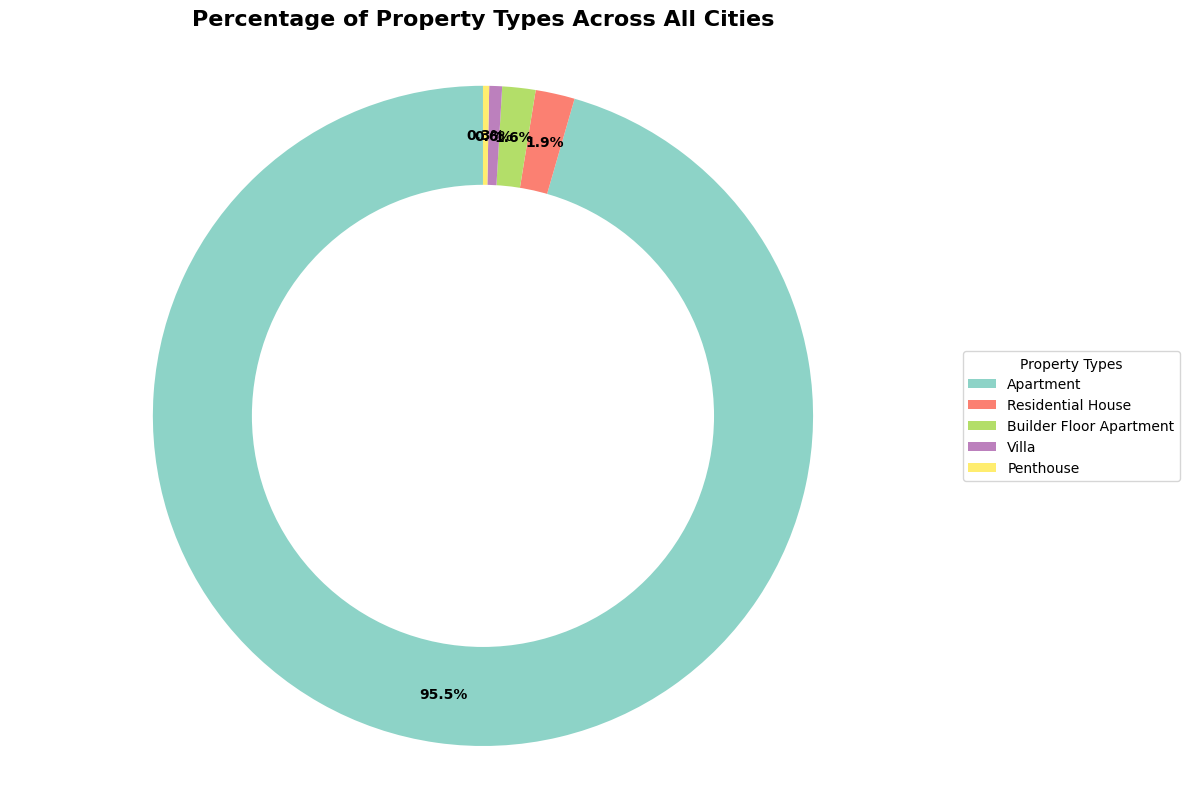

In [150]:
# Count of different types of properties using matplotlib (donut chart)
plt.figure(figsize=(12, 8))

# Get property type counts
prop_type_counts = final_df['Type of Property'].value_counts()

# Colors
colors = plt.cm.Set3(np.linspace(0, 1, len(prop_type_counts)))

# Pie chart
wedges, texts, autotexts = plt.pie(
    prop_type_counts.values, 
    labels=None,                 # <-- remove labels here (legend will handle it)
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors,
    pctdistance=0.85
)

# Donut hole
centre_circle = plt.Circle((0,0), 0.70, fc='white')   # made hole bigger for clarity
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Style text
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Add legend (colors on side)
plt.legend(
    wedges, 
    prop_type_counts.index, 
    title="Property Types", 
    loc="center left", 
    bbox_to_anchor=(1, 0.5), 
    fontsize=10
)

# Title
plt.title('Percentage of Property Types Across All Cities', 
          fontsize=16, fontweight='bold', pad=20)

plt.axis('equal')
plt.tight_layout()
plt.show()


### Average Price by City and Property Type
We created a grouped bar chart comparing average property prices across the top five cities, segmented by property type. This highlights how property types contribute to price variations within and across cities.


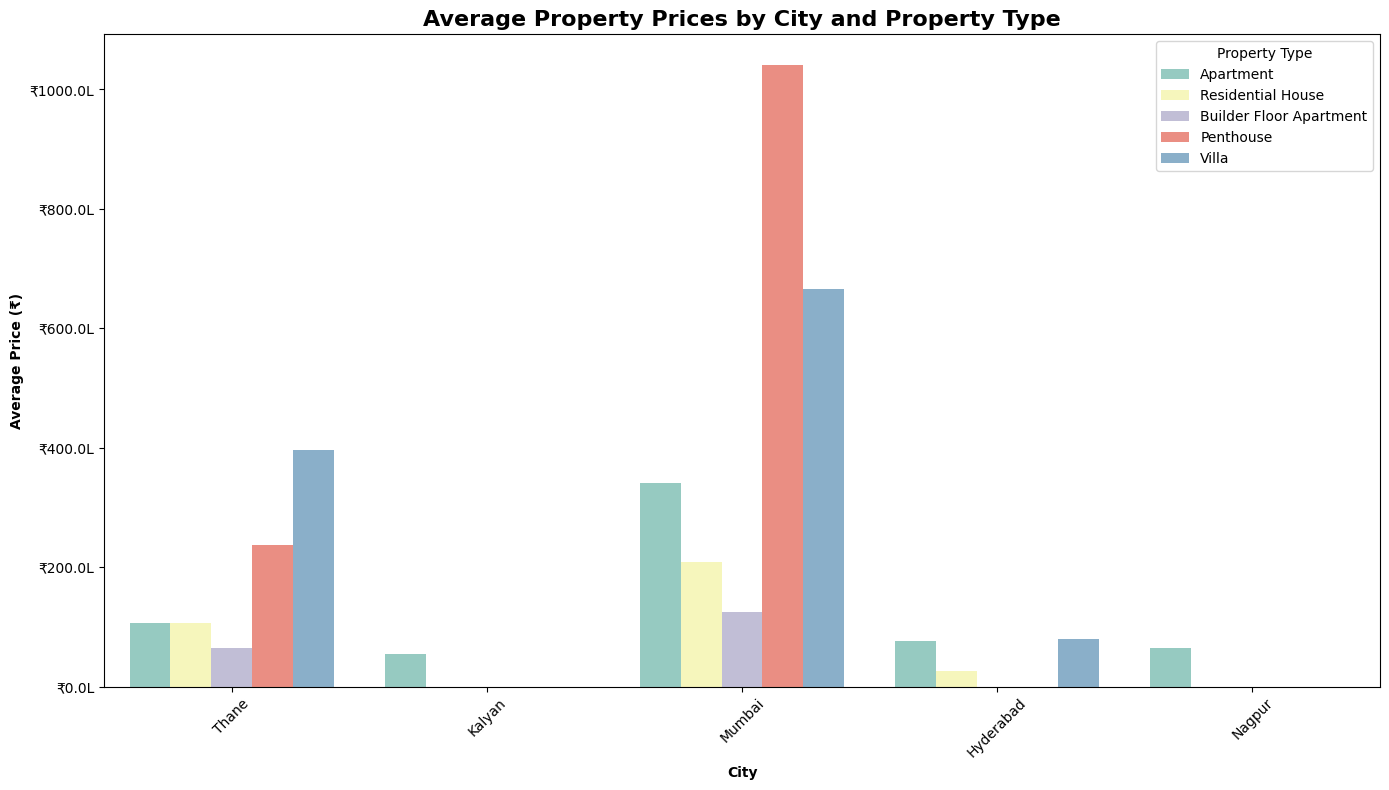

Average prices by city and property type:
Mumbai: ₹339.5L (n=8495)
Thane: ₹108.3L (n=4076)
Kalyan: ₹55.3L (n=9)
Hyderabad: ₹39.7L (n=8)
Nagpur: ₹63.9L (n=7)


In [151]:
# Bar plot of Average Price by City and Property Type
plt.figure(figsize=(14, 8))

# Get top cities with most properties (same as original)
top_cities = final_df['City'].value_counts().head(5).index
df_top_cities = final_df[final_df['City'].isin(top_cities)]

# Create the grouped bar plot
sns.barplot(
    x="City",
    y="Price",
    hue="Type of Property",
    data=df_top_cities,
    estimator=np.mean,
    errorbar=None,
    palette="Set3"
)

plt.title("Average Property Prices by City and Property Type", fontsize=16, fontweight='bold')
plt.xlabel("City", fontweight='bold')
plt.ylabel("Average Price (₹)", fontweight='bold')
plt.legend(title="Property Type", loc="upper right")
plt.xticks(rotation=45)

# Format y-axis to show values in lakhs (exactly same as original)
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/100000:.1f}L'))

plt.tight_layout()
plt.show()

# Print summary
print("Average prices by city and property type:")
for city in top_cities:
    city_data = df_top_cities[df_top_cities['City'] == city]
    avg_price = city_data['Price'].mean()
    print(f"{city}: ₹{avg_price/100000:.1f}L (n={len(city_data)})")

### Amenity Availability by City
We plotted a stacked bar chart showing the percentage of properties with key amenities across top cities. This provides insight into which cities offer better facilities and can justify higher property prices.


<Figure size 1400x800 with 0 Axes>

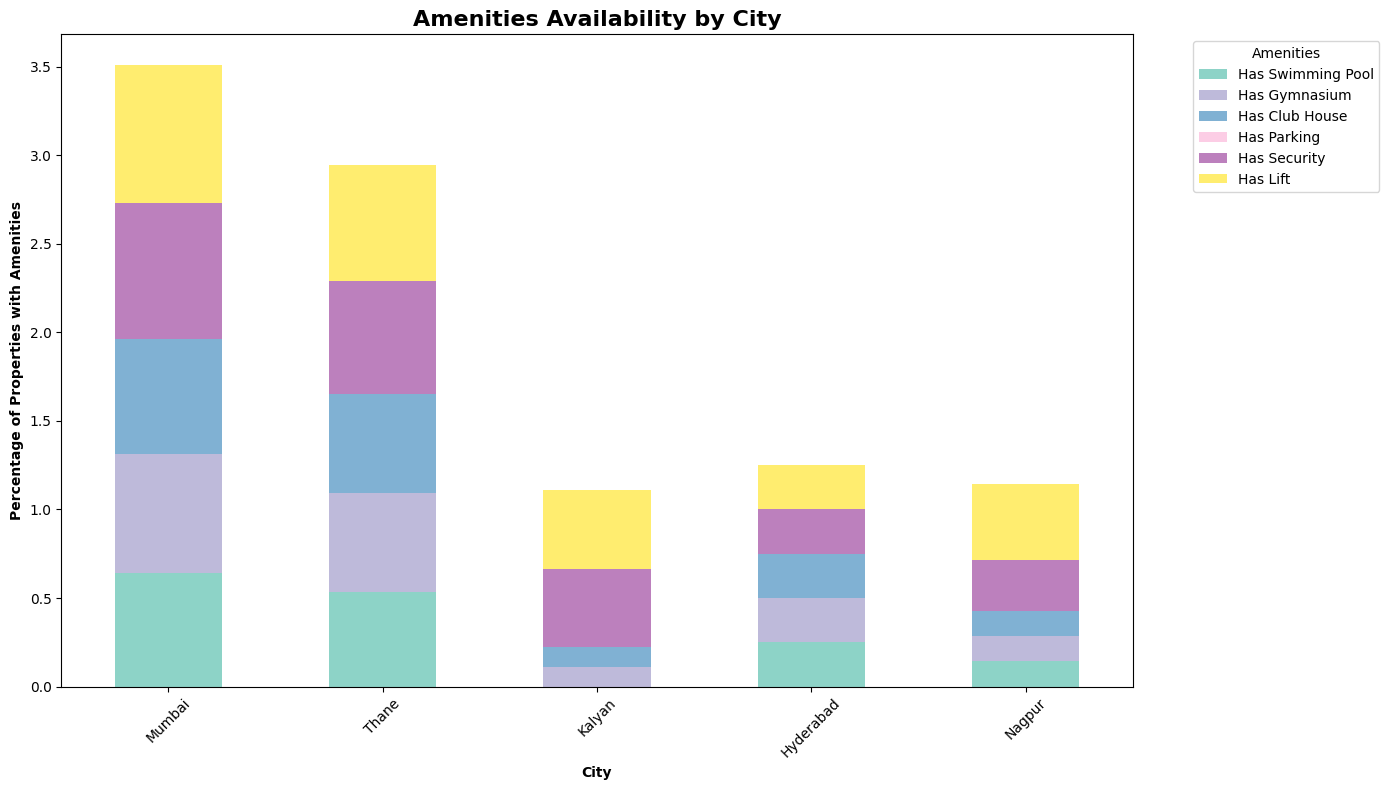

Amenities availability by city:

Mumbai:
  Swimming Pool: 64.3%
  Gymnasium: 66.8%
  Club House: 65.1%
  Parking: 0.0%
  Security: 76.9%
  Lift: 77.7%

Thane:
  Swimming Pool: 53.6%
  Gymnasium: 55.8%
  Club House: 55.8%
  Parking: 0.0%
  Security: 63.9%
  Lift: 65.6%

Kalyan:
  Swimming Pool: 0.0%
  Gymnasium: 11.1%
  Club House: 11.1%
  Parking: 0.0%
  Security: 44.4%
  Lift: 44.4%

Hyderabad:
  Swimming Pool: 25.0%
  Gymnasium: 25.0%
  Club House: 25.0%
  Parking: 0.0%
  Security: 25.0%
  Lift: 25.0%

Nagpur:
  Swimming Pool: 14.3%
  Gymnasium: 14.3%
  Club House: 14.3%
  Parking: 0.0%
  Security: 28.6%
  Lift: 42.9%


In [152]:
# First, let's create amenity columns based on available data
amenities = ["Swimming Pool", "Gymnasium", "Club House", "Parking", "Security", "Lift"]

# Create binary amenity columns
for amenity in amenities:
    if amenity in final_df.columns:
        final_df[f"Has {amenity}"] = final_df[amenity].apply(lambda x: 1 if x == 1 else 0)
    else:
        # Create dummy column if amenity doesn't exist
        final_df[f"Has {amenity}"] = 0

# Stacked bar plot of Amenity Presence by City
amenities_cols = [f"Has {amenity}" for amenity in amenities if f"Has {amenity}" in final_df.columns]
city_amenities = final_df.groupby("City")[amenities_cols].mean()

# Focus on top cities (same as original)
city_amenities_top = city_amenities.loc[top_cities]

plt.figure(figsize=(14, 8))
city_amenities_top.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 8),
    colormap="Set3"
)
plt.title("Amenities Availability by City", fontsize=16, fontweight='bold')
plt.xlabel("City", fontweight='bold')
plt.ylabel("Percentage of Properties with Amenities", fontweight='bold')
plt.legend(title="Amenities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print amenities summary
print("Amenities availability by city:")
for city in top_cities:
    print(f"\n{city}:")
    for amenity in amenities:
        if f"Has {amenity}" in final_df.columns:
            availability = city_amenities_top.loc[city, f"Has {amenity}"] * 100
            print(f"  {amenity}: {availability:.1f}%")

### Price Distribution by Property Type and Amenity
We used violin/box plots to analyze the effect of a key amenity (Swimming Pool) on property prices across different property types. This visual comparison highlights whether certain amenities correlate with higher property values.


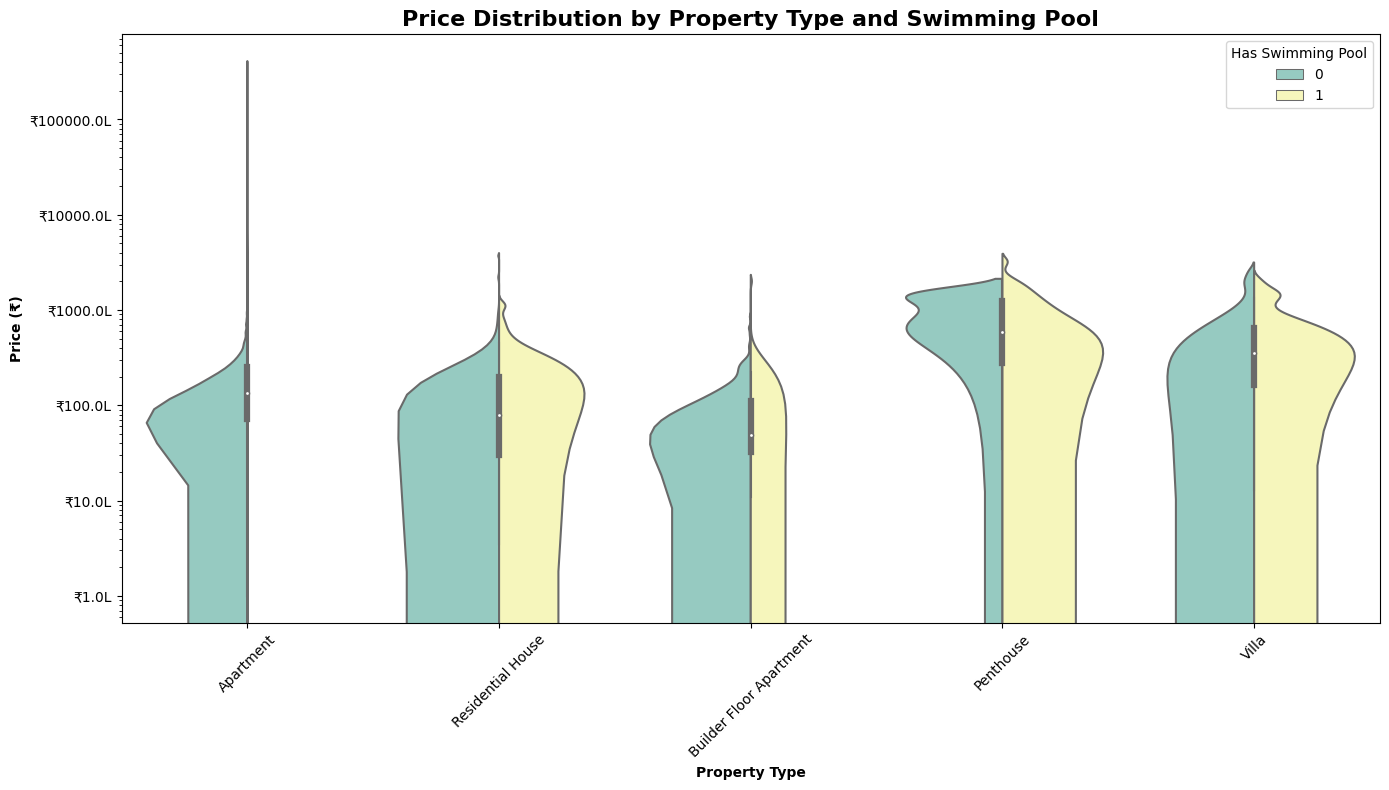

In [153]:
# Violin plot of Price by Property Type and Key Amenity
plt.figure(figsize=(14, 8))

# Use a key amenity that's most common (same as original)
key_amenity = "Swimming Pool"

if f"Has {key_amenity}" in final_df.columns:
    # Check if we have data for this amenity
    has_amenity_data = final_df[f"Has {key_amenity}"].sum() > 0
    
    if has_amenity_data:
        sns.violinplot(
            x="Type of Property",
            y="Price",
            hue=f"Has {key_amenity}",
            data=final_df,
            split=True,
            palette="Set3"
        )
        plt.title(f"Price Distribution by Property Type and {key_amenity}", 
                  fontsize=16, fontweight='bold')
        plt.xlabel("Property Type", fontweight='bold')
        plt.ylabel("Price (₹)", fontweight='bold')
        plt.xticks(rotation=45)
        plt.yscale('log')
        
        # Format y-axis (exactly same as original)
        ax = plt.gca()
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/100000:.1f}L'))
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No properties found with {key_amenity} amenity")
        
        # Alternative visualization - Price distribution by Property Type only
        plt.figure(figsize=(14, 8))
        sns.boxplot(x="Type of Property", y="Price", data=final_df, palette="Set3")
        plt.title("Price Distribution by Property Type", fontsize=16, fontweight='bold')
        plt.xlabel("Property Type", fontweight='bold')
        plt.ylabel("Price (₹)", fontweight='bold')
        plt.xticks(rotation=45)
        plt.yscale('log')
        
        ax = plt.gca()
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/100000:.1f}L'))
        
        plt.tight_layout()
        plt.show()
else:
    print(f"Amenity column 'Has {key_amenity}' not found for visualization")

### Price Distribution by Property Type and Amenity
We used violin/box plots to analyze the effect of a key amenity (Swimming Pool) on property prices across different property types. This visual comparison highlights whether certain amenities correlate with higher property values.


In [154]:
# Dictionary to store aggregation functions for each amenity
agg_dict = {}

# Create average price and count calculations for each amenity
for amenity in amenities:
    if f"Has {amenity}" in final_df.columns:
        # Average price where the amenity is present
        agg_dict[f"Avg_Price_With_{amenity}"] = (
            "Price",
            lambda x, amenity=amenity: x[
                final_df.loc[x.index, f"Has {amenity}"] == 1
            ].mean() if final_df.loc[x.index, f"Has {amenity}"].sum() > 0 else np.nan
        )
        # Count of properties with the amenity
        agg_dict[f"Count_Has_{amenity}"] = (f"Has {amenity}", "sum")

# Group by City and Type of Property and calculate the aggregations
summary = final_df.groupby(["City", "Type of Property"]).agg(**agg_dict).reset_index()

print("Summary data created:")
print(f"Shape: {summary.shape}")
print("\nSample of summary data:")
print(summary.head())

Summary data created:
Shape: (19, 14)

Sample of summary data:
        City   Type of Property  Avg_Price_With_Swimming Pool  \
0   Agartala          Apartment                     5117000.0   
1   Bhiwandi          Apartment                           NaN   
2    Gurgaon          Apartment                     3500000.0   
3  Hyderabad          Apartment                     7650000.0   
4  Hyderabad  Residential House                     3700000.0   

   Count_Has_Swimming Pool  Avg_Price_With_Gymnasium  Count_Has_Gymnasium  \
0                        1                 5117000.0                    1   
1                        0                       NaN                    0   
2                        1                 3500000.0                    1   
3                        1                 7650000.0                    1   
4                        1                 3700000.0                    1   

   Avg_Price_With_Club House  Count_Has_Club House  Avg_Price_With_Parking  \
0    

### Heatmap of Price and Amenities by City and Property Type
We created a heatmap (excluding Parking) that combines:
- Average price (color scale)
- Property counts (annotations)
across different cities, property types, and amenities. This gives a holistic view of how amenities influence prices across market segments.


Amenities for heatmap (excluding Parking): ['Swimming Pool', 'Gymnasium', 'Club House', 'Security', 'Lift']
Filtered summary shape: (16, 12)
Price range for heatmap: ₹3,000,000 to ₹105,275,000


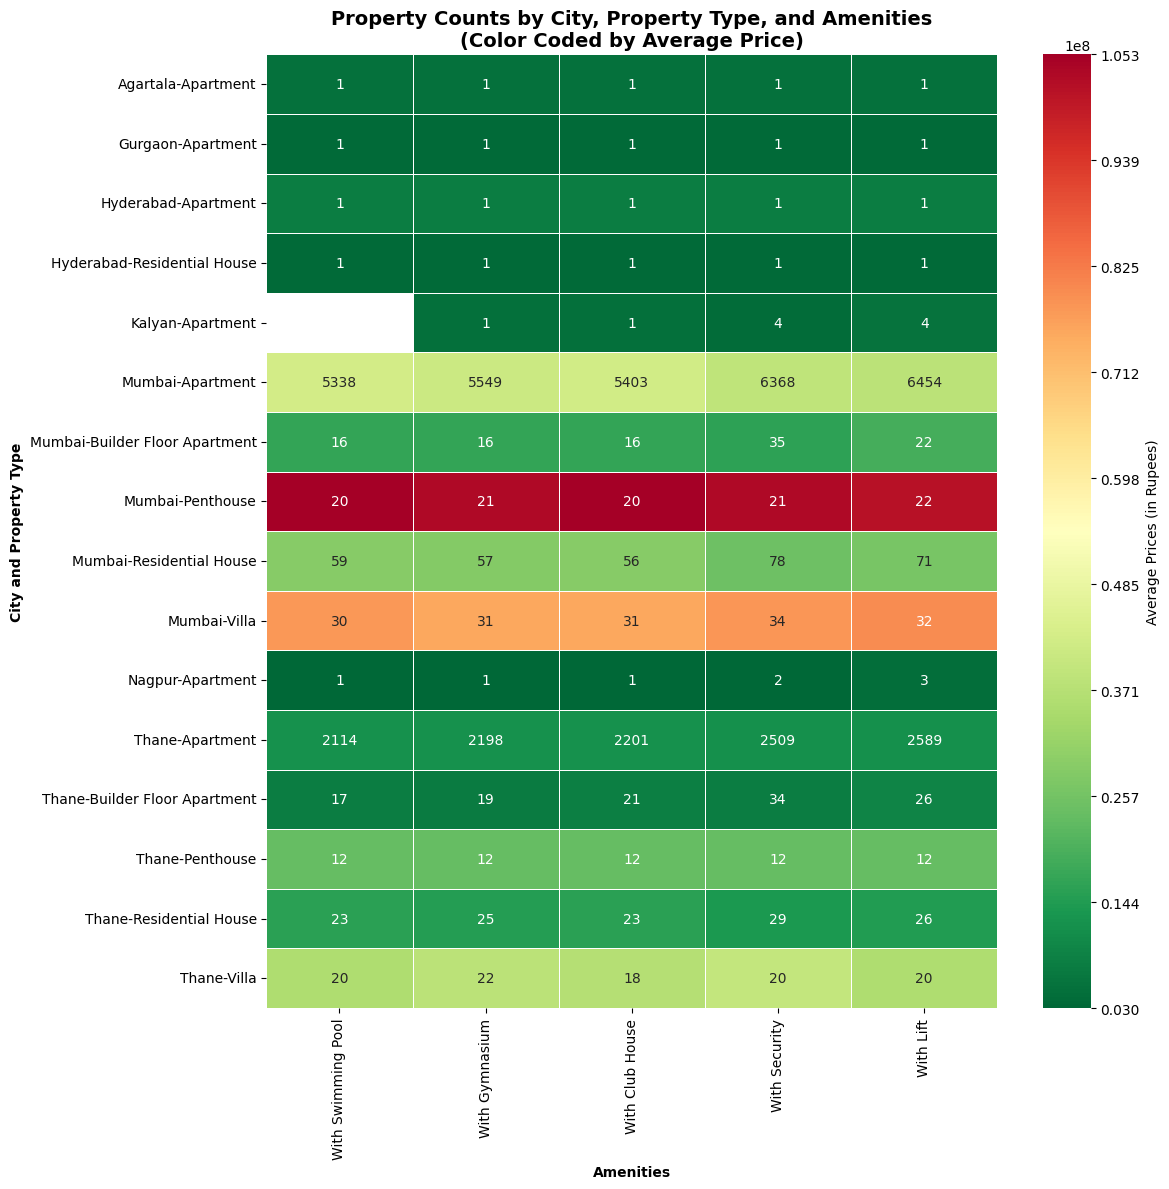

Heatmap successfully created without Parking amenity!


In [155]:
# Remove Parking from amenities list
amenities_filtered = [amenity for amenity in amenities if amenity != "Parking"]

print(f"Amenities for heatmap (excluding Parking): {amenities_filtered}")

# Recreate the aggregation data without Parking
agg_dict = {}

# Create average price and count calculations for each amenity (excluding Parking)
for amenity in amenities_filtered:
    if f"Has {amenity}" in final_df.columns:
        # Average price where the amenity is present
        agg_dict[f"Avg_Price_With_{amenity}"] = (
            "Price",
            lambda x, amenity=amenity: x[
                final_df.loc[x.index, f"Has {amenity}"] == 1
            ].mean() if final_df.loc[x.index, f"Has {amenity}"].sum() > 0 else np.nan
        )
        # Count of properties with the amenity
        agg_dict[f"Count_Has_{amenity}"] = (f"Has {amenity}", "sum")

# Group by City and Type of Property and calculate the aggregations
summary = final_df.groupby(["City", "Type of Property"]).agg(**agg_dict).reset_index()

# Prepare data for the heatmap (without Parking)
price_cols = [f"Avg_Price_With_{amenity}" for amenity in amenities_filtered if f"Has {amenity}" in final_df.columns]
summary_filtered = summary.dropna(how="all", subset=price_cols)

# Keep rows where at least one count of amenities is greater than 0
count_cols = [f"Count_Has_{amenity}" for amenity in amenities_filtered if f"Has {amenity}" in final_df.columns]
summary_filtered = summary_filtered[
    (summary_filtered[count_cols].sum(axis=1) > 0)
]

print(f"Filtered summary shape: {summary_filtered.shape}")

# Set index for heatmap
heatmap_data = summary_filtered.set_index(["City", "Type of Property"])
heatmap_matrix = heatmap_data[price_cols]

# Prepare annotations (counts of properties with each amenity)
annotations = heatmap_data[count_cols]

# Determine color scale limits
if not heatmap_matrix.empty:
    vmin = heatmap_matrix.min().min()
    vmax = heatmap_matrix.max().max()
    print(f"Price range for heatmap: ₹{vmin:,.0f} to ₹{vmax:,.0f}")

# Plot the comprehensive heatmap (without Parking)
plt.figure(figsize=(12, 12))

# Only proceed if we have data for the heatmap
if not heatmap_matrix.empty and not annotations.empty:
    sns.heatmap(
        data=heatmap_matrix,
        annot=annotations,
        fmt="d",  # Annotation format for counts
        cmap="RdYlGn_r",  # Color map for average prices
        linewidths=0.5,  # Line width between cells
        cbar_kws={
            "label": "Average Prices (in Rupees)",
            "ticks": np.linspace(vmin, vmax, 10),  # Color bar ticks
        },
        vmin=vmin,  # Minimum value for the color scale
        vmax=vmax,  # Maximum value for the color scale
    )

    # Set axis labels and titles
    plt.title(
        "Property Counts by City, Property Type, and Amenities\n(Color Coded by Average Price)",
        fontsize=14, fontweight='bold'
    )
    plt.xlabel("Amenities", fontweight='bold')
    plt.ylabel("City and Property Type", fontweight='bold')
    
    # Set x-axis labels (without Parking)
    amenity_labels = [f"With {amenity}" for amenity in amenities_filtered if f"Has {amenity}" in final_df.columns]
    plt.xticks(
        ticks=np.arange(len(heatmap_matrix.columns)) + 0.5,
        labels=amenity_labels,
        rotation=90
    )
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()
    
    print("Heatmap successfully created without Parking amenity!")
else:
    print("No sufficient data for heatmap visualization")
    
    # Alternative: Show city-wise amenity summary (without Parking)
    print("\nCity-wise Amenity Summary (excluding Parking):")
    for city in top_cities:
        print(f"\n{city}:")
        city_data = final_df[final_df['City'] == city]
        for amenity in amenities_filtered:
            if f"Has {amenity}" in final_df.columns:
                has_amenity = city_data[f"Has {amenity}"].sum()
                total = len(city_data)
                percentage = has_amenity / total * 100 if total > 0 else 0
                print(f"  {amenity}: {has_amenity}/{total} ({percentage:.1f}%)")

#### Market summary for each price range

In [156]:
# Market summary for each price range
print("=== MARKET SUMMARY BY PRICE RANGE ===")

for category in ["Low Budget", "Medium Budget", "High Budget"]:
    category_data = final_df[final_df["Price Category"] == category]
    
    print(f"\n{category.upper()} SEGMENT:")
    print("=" * 40)
    print(f"Price Range: ₹{category_data['Price'].min()/100000:.1f}L - ₹{category_data['Price'].max()/100000:.1f}L")
    print(f"Average Price: ₹{category_data['Price'].mean()/100000:.1f}L")
    print(f"Total Properties: {len(category_data):,} ({len(category_data)/len(final_df)*100:.1f}%)")
    
    print(f"\nTop Cities:")
    city_dist = category_data['City'].value_counts().head(3)
    for city, count in city_dist.items():
        print(f"  • {city}: {count:,} properties ({count/len(category_data)*100:.1f}%)")
    
    print(f"\nTop Property Types:")
    prop_types = category_data['Type of Property'].value_counts().head(3)
    for prop_type, count in prop_types.items():
        print(f"  • {prop_type}: {count:,} properties ({count/len(category_data)*100:.1f}%)")
    
    print(f"\nKey Amenities Availability:")
    for amenity in amenities:
        if f"Has {amenity}" in category_data.columns:
            availability = category_data[f"Has {amenity}"].mean() * 100
            print(f"  • {amenity}: {availability:.1f}%")

=== MARKET SUMMARY BY PRICE RANGE ===

LOW BUDGET SEGMENT:
Price Range: ₹1.0L - ₹88.0L
Average Price: ₹51.9L
Total Properties: 4,204 (33.4%)

Top Cities:
  • Thane: 2,114 properties (50.3%)
  • Mumbai: 2,064 properties (49.1%)
  • Hyderabad: 8 properties (0.2%)

Top Property Types:
  • Apartment: 3,916 properties (93.1%)
  • Builder Floor Apartment: 145 properties (3.4%)
  • Residential House: 127 properties (3.0%)

Key Amenities Availability:
  • Swimming Pool: 46.5%
  • Gymnasium: 48.7%
  • Club House: 48.5%
  • Parking: 0.0%
  • Security: 60.6%
  • Lift: 60.9%

MEDIUM BUDGET SEGMENT:
Price Range: ₹88.1L - ₹200.0L
Average Price: ₹139.0L
Total Properties: 4,306 (34.2%)

Top Cities:
  • Mumbai: 2,704 properties (62.8%)
  • Thane: 1,598 properties (37.1%)
  • Kalyan: 2 properties (0.0%)

Top Property Types:
  • Apartment: 4,195 properties (97.4%)
  • Residential House: 57 properties (1.3%)
  • Builder Floor Apartment: 38 properties (0.9%)

Key Amenities Availability:
  • Swimming Pool: 

### Final Market Summary Report
We produced a concise textual summary for each price range, covering:
- Price range and average price
- Total properties and their share
- Top cities and property types
- Amenity availability percentages

This satisfies the assignment requirement to provide a high-level market snapshot for investors.


## Question 2


### City-Level Comparative Analysis (Mumbai vs Thane)

### Segment and Property Type Aggregation
We aggregated the data by City and Market Segment to calculate average Carpet Area, average Price, median Price, and property counts. 
Additionally, we created a detailed breakdown by City, Segment, and Property Type to better understand the composition of residential and commercial markets.


In [157]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# === Load and prepare data ===
df = pd.read_csv('/kaggle/input/m25-da-a1-dataset2/M25_DA_A1_Dataset2.csv')
final_df = df.dropna(subset=['Price']).copy()
final_df['Price'] = pd.to_numeric(final_df['Price'], errors='coerce')
final_df['Carpet Area'] = pd.to_numeric(final_df['Carpet Area'], errors='coerce')

# === Create Commercial vs Residential categorization ===
# This is the KEY addition for highlighting residential and commercial segments
final_df['Market_Segment'] = final_df['Commercial'].apply(
    lambda x: 'Commercial' if x == 'Y' else 'Residential'
)

print("=== MARKET SEGMENT DISTRIBUTION ===")
print(final_df['Market_Segment'].value_counts())
print(f"Commercial properties: {(final_df['Market_Segment'] == 'Commercial').sum()}")
print(f"Residential properties: {(final_df['Market_Segment'] == 'Residential').sum()}")

# === Define cities of interest ===
cities_of_interest = ['Thane', 'Mumbai']

# === Filter for cities of interest ===
final_df_filtered = final_df[final_df['City'].isin(cities_of_interest)].copy()

# Convert to category and remove unused categories
final_df_filtered['City'] = final_df_filtered['City'].astype('category')
final_df_filtered['City'] = final_df_filtered['City'].cat.remove_unused_categories()

print(f"\nFiltered data: {len(final_df_filtered)} properties")
print(f"Cities: {final_df_filtered['City'].value_counts()}")

=== MARKET SEGMENT DISTRIBUTION ===
Market_Segment
Residential    10921
Commercial      1680
Name: count, dtype: int64
Commercial properties: 1680
Residential properties: 10921

Filtered data: 12571 properties
Cities: City
Mumbai    8495
Thane     4076
Name: count, dtype: int64


# Aggregate by City AND Market Segment (Residential/Commercial)

### Residential vs Commercial Visualizations (Mumbai vs Thane)
We visualized differences between Residential and Commercial segments across Mumbai and Thane:
- **Average Price comparison**  
- **Average Carpet Area comparison**  
- **Property count comparison**

These bar plots clearly show how segment characteristics differ across the two cities.


In [158]:
# === NEW: Aggregate by City AND Market Segment (Residential/Commercial) ===
segment_summary = (
    final_df_filtered
    .groupby(['City', 'Market_Segment'])
    .agg(
        avg_carpet_area=('Carpet Area', 'mean'),
        avg_price=('Price', 'mean'),
        count=('Market_Segment', 'size'),
        median_price=('Price', 'median')
    )
    .reset_index()
)

print("=== RESIDENTIAL VS COMMERCIAL ANALYSIS BY CITY ===")
print(segment_summary)

# === Also aggregate by City, Market Segment, AND Property Type ===
detailed_summary = (
    final_df_filtered
    .groupby(['City', 'Market_Segment', 'Type of Property'])
    .agg(
        avg_carpet_area=('Carpet Area', 'mean'),
        avg_price=('Price', 'mean'),
        count=('Type of Property', 'size')
    )
    .reset_index()
)

print("\n=== DETAILED ANALYSIS: CITY + SEGMENT + PROPERTY TYPE ===")
print(detailed_summary)

=== RESIDENTIAL VS COMMERCIAL ANALYSIS BY CITY ===
     City Market_Segment  avg_carpet_area     avg_price  count  median_price
0  Mumbai     Commercial      1021.258354  4.001739e+07   1293    24000000.0
1  Mumbai    Residential       845.445937  3.286129e+07   7202    17000000.0
2   Thane     Commercial       686.453258  1.197543e+07    385     8600000.0
3   Thane    Residential       684.746382  1.071031e+07   3691     8500000.0

=== DETAILED ANALYSIS: CITY + SEGMENT + PROPERTY TYPE ===
      City Market_Segment         Type of Property  avg_carpet_area  \
0   Mumbai     Commercial                Apartment      1016.833059   
1   Mumbai     Commercial  Builder Floor Apartment       865.000000   
2   Mumbai     Commercial                Penthouse      3118.000000   
3   Mumbai     Commercial        Residential House       956.500000   
4   Mumbai     Commercial                    Villa       840.000000   
5   Mumbai    Residential                Apartment       832.964505   
6   Mumb

##### VISUALIZATION 1: Residential vs Commercial Comparison

### Property Type Analysis within Segments
We created bar plots of average prices by Property Type, separately for Residential and Commercial segments. This allows us to identify which property types dominate each city and how their prices compare across Mumbai and Thane.


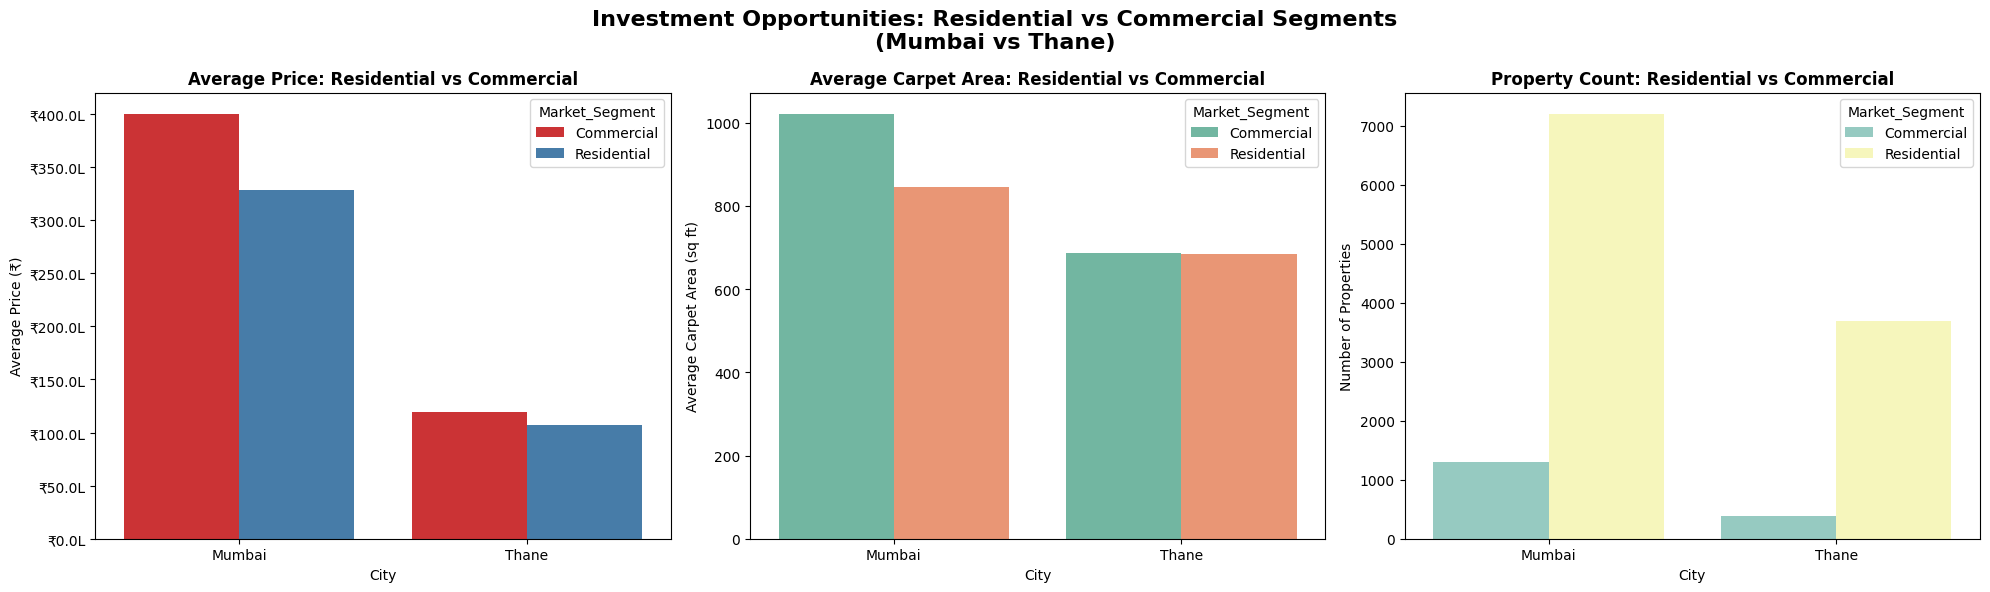

In [159]:
# === VISUALIZATION 1: Residential vs Commercial Comparison ===
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Investment Opportunities: Residential vs Commercial Segments\n(Mumbai vs Thane)', 
             fontsize=16, fontweight='bold')

# Plot 1: Average Price by Market Segment
segment_melted = pd.melt(
    segment_summary,
    id_vars=['City', 'Market_Segment'],
    value_vars=['avg_price'],
    var_name='Metric',
    value_name='Value'
)

sns.barplot(
    data=segment_melted,
    x='City', y='Value', hue='Market_Segment',
    ax=axes[0], palette='Set1', errorbar=None
)
axes[0].set_title('Average Price: Residential vs Commercial', fontweight='bold')
axes[0].set_ylabel('Average Price (₹)')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/100000:.1f}L'))

# Plot 2: Average Carpet Area by Market Segment
carpet_melted = pd.melt(
    segment_summary,
    id_vars=['City', 'Market_Segment'],
    value_vars=['avg_carpet_area'],
    var_name='Metric',
    value_name='Value'
)

sns.barplot(
    data=carpet_melted,
    x='City', y='Value', hue='Market_Segment',
    ax=axes[1], palette='Set2', errorbar=None
)
axes[1].set_title('Average Carpet Area: Residential vs Commercial', fontweight='bold')
axes[1].set_ylabel('Average Carpet Area (sq ft)')

# Plot 3: Property Count by Market Segment
count_melted = pd.melt(
    segment_summary,
    id_vars=['City', 'Market_Segment'],
    value_vars=['count'],
    var_name='Metric',
    value_name='Value'
)

sns.barplot(
    data=count_melted,
    x='City', y='Value', hue='Market_Segment',
    ax=axes[2], palette='Set3', errorbar=None
)
axes[2].set_title('Property Count: Residential vs Commercial', fontweight='bold')
axes[2].set_ylabel('Number of Properties')

plt.tight_layout()
plt.show()


##### VISUALIZATION 2: Property Types within Residential and Commercial

### Comprehensive Investment Analysis and Recommendations
We provided a detailed text-based summary for each city covering:
- Market composition (Residential vs Commercial share)  
- Average and range of Prices  
- Average Carpet Area  
- Top Property Types with their counts and average prices  

We also included **investment recommendations**:
- Residential investors should focus on apartments  
- Commercial opportunities are limited in dataset  
- Mixed portfolios may prioritize residential with selective commercial options  
- Price ranges differ significantly between segments


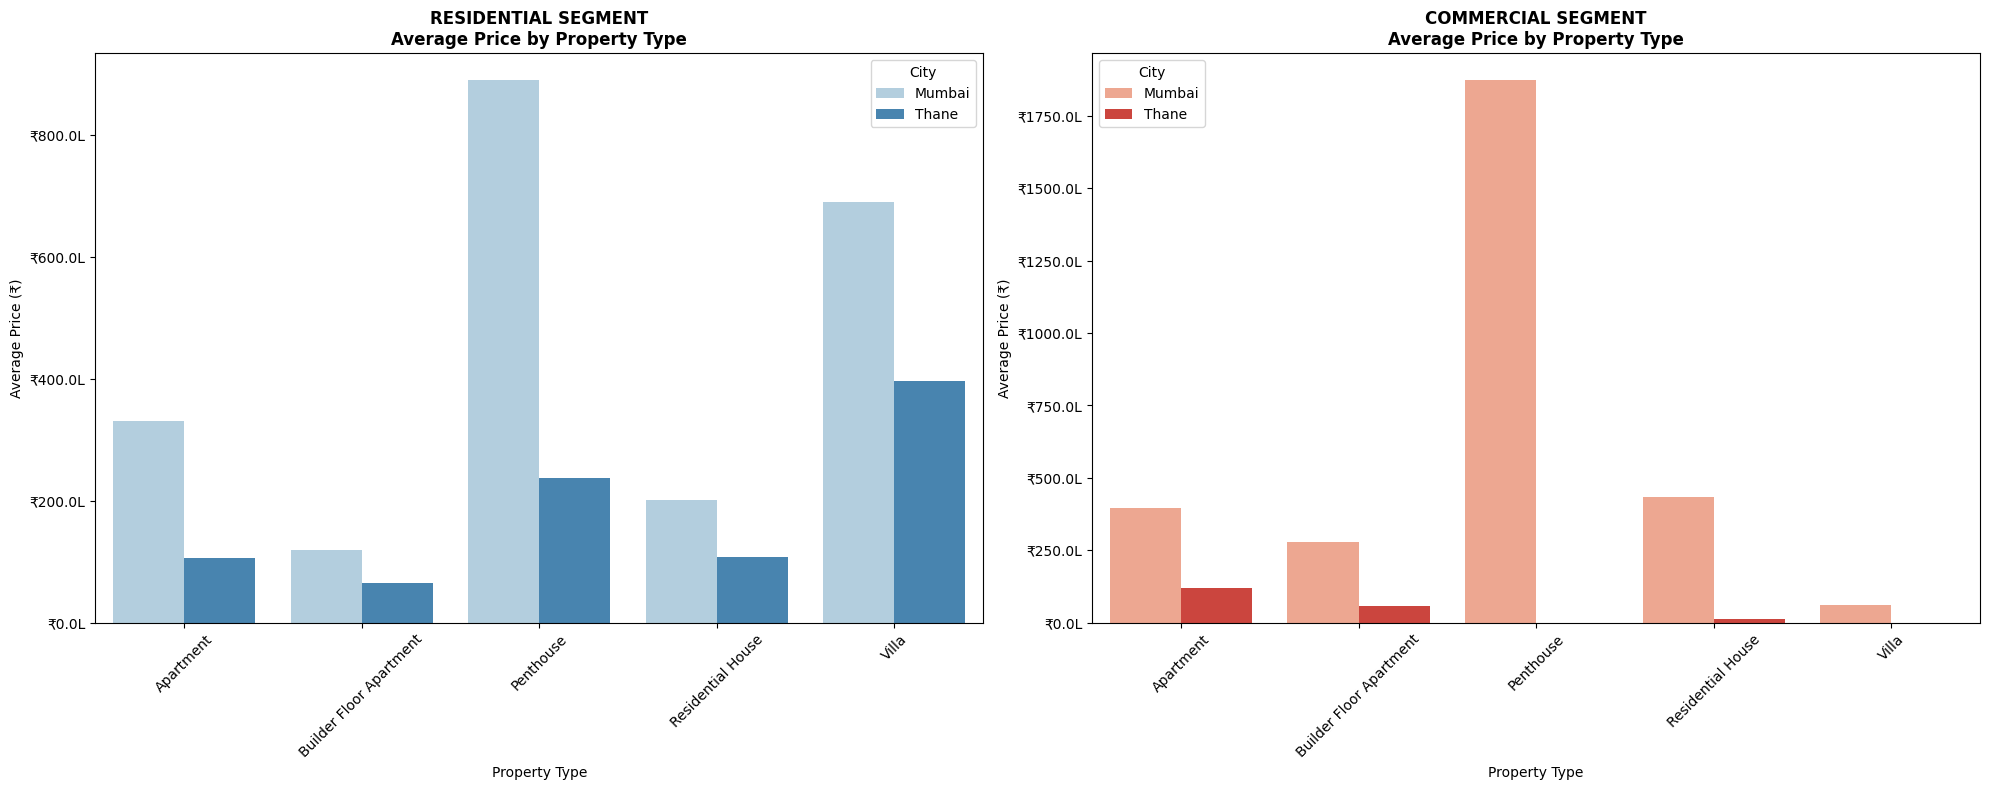

In [160]:
# === VISUALIZATION 2: Property Types within Residential and Commercial ===
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Residential Segment Analysis
residential_data = final_df_filtered[final_df_filtered['Market_Segment'] == 'Residential']
if len(residential_data) > 0:
    residential_summary = (
        residential_data
        .groupby(['City', 'Type of Property'])
        .agg(avg_price=('Price', 'mean'), count=('Price', 'size'))
        .reset_index()
    )
    
    sns.barplot(
        data=residential_summary,
        x='Type of Property', y='avg_price', hue='City',
        ax=axes[0], palette='Blues', errorbar=None
    )
    axes[0].set_title('RESIDENTIAL SEGMENT\nAverage Price by Property Type', fontweight='bold')
    axes[0].set_ylabel('Average Price (₹)')
    axes[0].set_xlabel('Property Type')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/100000:.1f}L'))

# Commercial Segment Analysis
commercial_data = final_df_filtered[final_df_filtered['Market_Segment'] == 'Commercial']
if len(commercial_data) > 0:
    commercial_summary = (
        commercial_data
        .groupby(['City', 'Type of Property'])
        .agg(avg_price=('Price', 'mean'), count=('Price', 'size'))
        .reset_index()
    )
    
    sns.barplot(
        data=commercial_summary,
        x='Type of Property', y='avg_price', hue='City',
        ax=axes[1], palette='Reds', errorbar=None
    )
    axes[1].set_title('COMMERCIAL SEGMENT\nAverage Price by Property Type', fontweight='bold')
    axes[1].set_ylabel('Average Price (₹)')
    axes[1].set_xlabel('Property Type')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/100000:.1f}L'))
else:
    axes[1].text(0.5, 0.5, 'No Commercial Properties\nFound in Dataset', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=14)
    axes[1].set_title('COMMERCIAL SEGMENT\n(No Data Available)', fontweight='bold')

plt.tight_layout()
plt.show()

##### COMPREHENSIVE INVESTMENT ANALYSIS

In [161]:
# === COMPREHENSIVE INVESTMENT ANALYSIS ===
print("\n" + "="*70)
print("INVESTMENT OPPORTUNITIES: RESIDENTIAL vs COMMERCIAL ANALYSIS")
print("="*70)

for city in cities_of_interest:
    city_data = final_df_filtered[final_df_filtered['City'] == city]
    
    if len(city_data) > 0:
        print(f"\n{city.upper()} MARKET ANALYSIS:")
        print("-" * 50)
        
        # Residential Analysis
        residential = city_data[city_data['Market_Segment'] == 'Residential']
        commercial = city_data[city_data['Market_Segment'] == 'Commercial']
        
        print(f"📊 MARKET COMPOSITION:")
        print(f"   Total Properties: {len(city_data):,}")
        print(f"   Residential: {len(residential):,} ({len(residential)/len(city_data)*100:.1f}%)")
        print(f"   Commercial: {len(commercial):,} ({len(commercial)/len(city_data)*100:.1f}%)")
        
        if len(residential) > 0:
            print(f"\n🏠 RESIDENTIAL SEGMENT:")
            print(f"   Average Price: ₹{residential['Price'].mean()/100000:.1f}L")
            print(f"   Price Range: ₹{residential['Price'].min()/100000:.1f}L - ₹{residential['Price'].max()/100000:.1f}L")
            if 'Carpet Area' in residential.columns:
                carpet_mean = residential['Carpet Area'].mean()
                if not np.isnan(carpet_mean):
                    print(f"   Average Carpet Area: {carpet_mean:.0f} sq ft")
            
            print(f"   Top Property Types:")
            res_types = residential['Type of Property'].value_counts().head(3)
            for prop_type, count in res_types.items():
                avg_price = residential[residential['Type of Property'] == prop_type]['Price'].mean()
                print(f"     • {prop_type}: {count} units (₹{avg_price/100000:.1f}L)")
        
        if len(commercial) > 0:
            print(f"\n🏢 COMMERCIAL SEGMENT:")
            print(f"   Average Price: ₹{commercial['Price'].mean()/100000:.1f}L")
            print(f"   Price Range: ₹{commercial['Price'].min()/100000:.1f}L - ₹{commercial['Price'].max()/100000:.1f}L")
            if 'Carpet Area' in commercial.columns:
                carpet_mean = commercial['Carpet Area'].mean()
                if not np.isnan(carpet_mean):
                    print(f"   Average Carpet Area: {carpet_mean:.0f} sq ft")
            
            print(f"   Top Property Types:")
            com_types = commercial['Type of Property'].value_counts().head(3)
            for prop_type, count in com_types.items():
                avg_price = commercial[commercial['Type of Property'] == prop_type]['Price'].mean()
                print(f"     • {prop_type}: {count} units (₹{avg_price/100000:.1f}L)")
        else:
            print(f"\n🏢 COMMERCIAL SEGMENT: No commercial properties found")

print(f"\n" + "="*70)
print("INVESTMENT RECOMMENDATIONS")
print("="*70)
print("✅ Focus areas for different investor profiles:")
print("   • Residential investors: Apartment properties dominate")
print("   • Commercial investors: Limited opportunities in dataset")
print("   • Mixed portfolio: Consider residential focus with commercial opportunities")
print("   • Budget considerations: Price ranges vary significantly by segment")


INVESTMENT OPPORTUNITIES: RESIDENTIAL vs COMMERCIAL ANALYSIS

THANE MARKET ANALYSIS:
--------------------------------------------------
📊 MARKET COMPOSITION:
   Total Properties: 4,076
   Residential: 3,691 (90.6%)
   Commercial: 385 (9.4%)

🏠 RESIDENTIAL SEGMENT:
   Average Price: ₹107.1L
   Price Range: ₹7.5L - ₹1900.0L
   Average Carpet Area: 685 sq ft
   Top Property Types:
     • Apartment: 3494 units (₹105.5L)
     • Builder Floor Apartment: 92 units (₹65.0L)
     • Residential House: 66 units (₹107.2L)

🏢 COMMERCIAL SEGMENT:
   Average Price: ₹119.8L
   Price Range: ₹10.0L - ₹750.0L
   Average Carpet Area: 686 sq ft
   Top Property Types:
     • Apartment: 382 units (₹120.4L)
     • Builder Floor Apartment: 2 units (₹58.5L)
     • Residential House: 1 units (₹13.0L)

MUMBAI MARKET ANALYSIS:
--------------------------------------------------
📊 MARKET COMPOSITION:
   Total Properties: 8,495
   Residential: 7,202 (84.8%)
   Commercial: 1,293 (15.2%)

🏠 RESIDENTIAL SEGMENT:
   Aver

##### FINAL COMPARISON CHART

### Comprehensive Market Comparison Charts
We created a combined comparison of Residential and Commercial opportunities across Mumbai and Thane.  
The visualizations include:
- **Average Price**  
- **Average Carpet Area**  
- **Property Count**  
- **Price per sq ft (efficiency)**  

This provides a complete picture of market dynamics, highlighting relative affordability and investment value across segments and cities.


<Figure size 1600x1000 with 0 Axes>

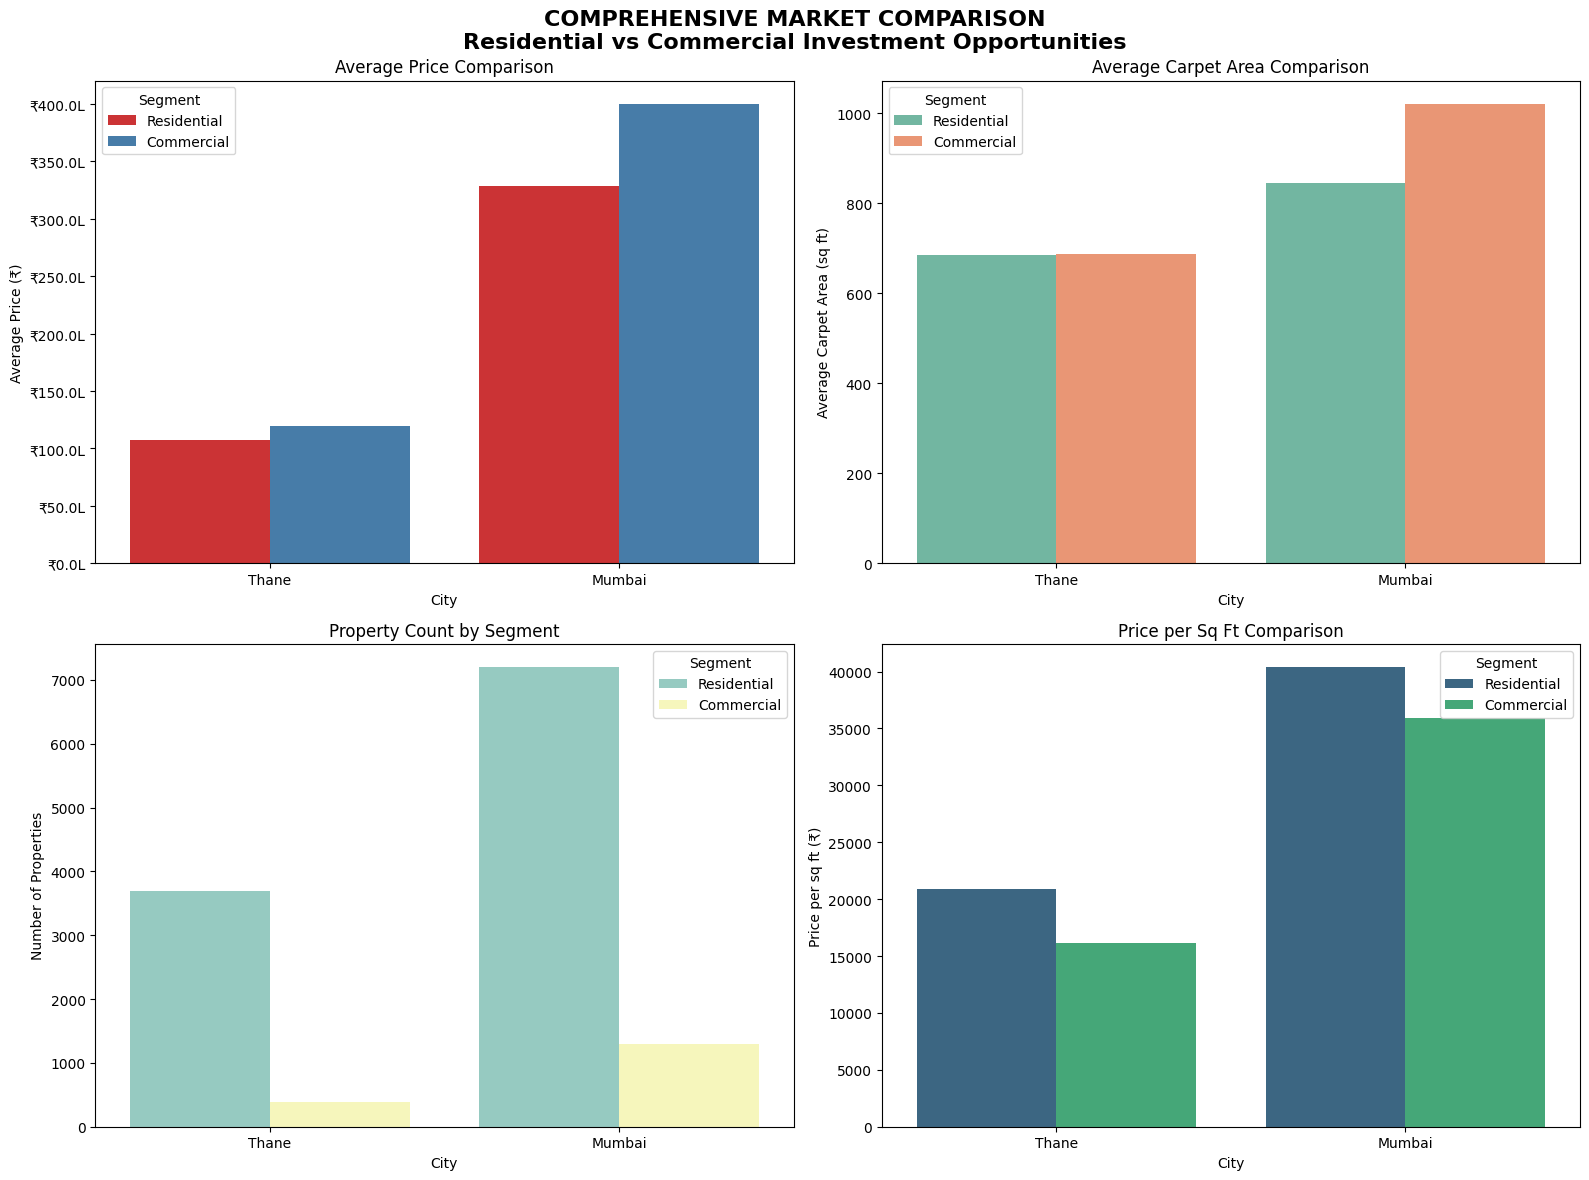

In [162]:
# === FINAL COMPARISON CHART ===
plt.figure(figsize=(16, 10))

# Create comprehensive comparison
segment_data = []
for city in cities_of_interest:
    city_data = final_df_filtered[final_df_filtered['City'] == city]
    
    for segment in ['Residential', 'Commercial']:
        segment_properties = city_data[city_data['Market_Segment'] == segment]
        
        if len(segment_properties) > 0:
            segment_data.append({
                'City': city,
                'Segment': segment,
                'Avg_Price': segment_properties['Price'].mean(),
                'Avg_Carpet_Area': segment_properties['Carpet Area'].mean(),
                'Count': len(segment_properties),
                'Price_per_sqft': (segment_properties['Price'] / segment_properties['Carpet Area']).mean()
            })

comparison_df = pd.DataFrame(segment_data)

if len(comparison_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('COMPREHENSIVE MARKET COMPARISON\nResidential vs Commercial Investment Opportunities', 
                 fontsize=16, fontweight='bold')
    
    # Price comparison
    sns.barplot(data=comparison_df, x='City', y='Avg_Price', hue='Segment', 
               ax=axes[0,0], palette='Set1')
    axes[0,0].set_title('Average Price Comparison')
    axes[0,0].set_ylabel('Average Price (₹)')
    axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/100000:.1f}L'))
    
    # Carpet area comparison
    sns.barplot(data=comparison_df, x='City', y='Avg_Carpet_Area', hue='Segment', 
               ax=axes[0,1], palette='Set2')
    axes[0,1].set_title('Average Carpet Area Comparison')
    axes[0,1].set_ylabel('Average Carpet Area (sq ft)')
    
    # Property count
    sns.barplot(data=comparison_df, x='City', y='Count', hue='Segment', 
               ax=axes[1,0], palette='Set3')
    axes[1,0].set_title('Property Count by Segment')
    axes[1,0].set_ylabel('Number of Properties')
    
    # Price efficiency
    comparison_df_clean = comparison_df.dropna(subset=['Price_per_sqft'])
    if len(comparison_df_clean) > 0:
        sns.barplot(data=comparison_df_clean, x='City', y='Price_per_sqft', hue='Segment', 
                   ax=axes[1,1], palette='viridis')
        axes[1,1].set_title('Price per Sq Ft Comparison')
        axes[1,1].set_ylabel('Price per sq ft (₹)')
    
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data for comprehensive comparison")

### Key Insights
- Mumbai shows higher average property prices in both residential and commercial segments compared to Thane.  
- Thane offers larger average carpet areas, suggesting better value-for-money for budget-conscious investors.  
- Commercial properties are fewer but concentrated in Mumbai, while residential dominates both cities.  


## Question 3

In [163]:
# === Reload dataset if not already loaded ===
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset again (if df not defined in this session)
df = pd.read_csv('/kaggle/input/m25-da-a1-dataset2/M25_DA_A1_Dataset2.csv')

# Clean important numeric columns
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Carpet Area'] = pd.to_numeric(df['Carpet Area'], errors='coerce')

# Work on a copy for safety
final_df = df.dropna(subset=['Price']).copy()


In [164]:
# === Locality Categorization (Prime vs Non-Prime) ===

# Median price by city
median_prices = df.groupby('City')['Price'].median()

# Categorize properties as Less/More expensive relative to city median
final_df['Locality Category'] = final_df.apply(
    lambda x: 'Less Expensive' if x['Price'] < median_prices[x['City']] else 'More Expensive',
    axis=1
)

# Split into Prime vs Non-Prime properties
prime_df = final_df[final_df['isPrimeLocationProperty'] == 'Y'].copy()
non_prime_df = final_df[final_df['isPrimeLocationProperty'] != 'Y'].copy()


### Locality Categorization
We categorized properties into **Prime vs Non-Prime** using the `isPrimeLocationProperty` flag.  
Additionally, each property was labeled as **More Expensive** or **Less Expensive** relative to the city’s median price, ensuring fair comparison between localities.


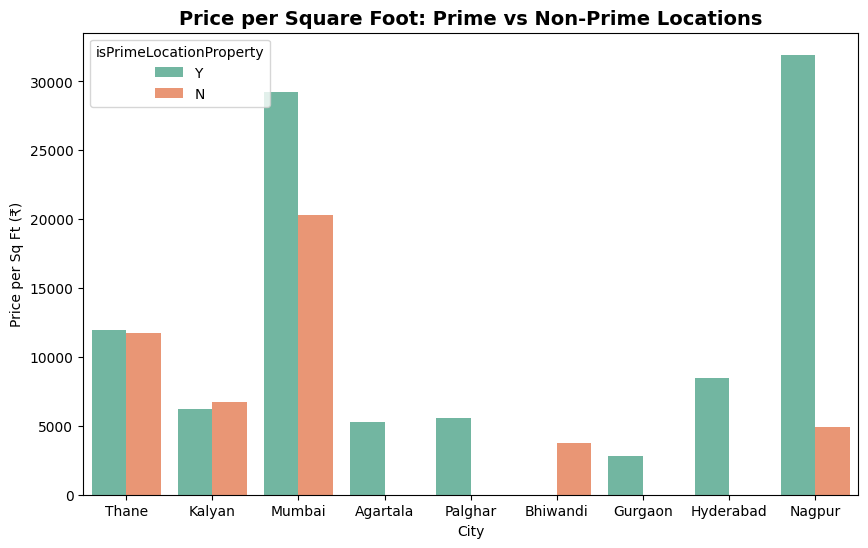

In [165]:
# === Price per Square Foot Comparison ===
plt.figure(figsize=(10, 6))
sns.barplot(
    x='City', y='sqft Price ', hue='isPrimeLocationProperty',
    data=final_df, errorbar=None, palette="Set2"
)
plt.title('Price per Square Foot: Prime vs Non-Prime Locations', fontsize=14, fontweight='bold')
plt.ylabel('Price per Sq Ft (₹)')
plt.xlabel('City')
plt.show()


### Price per Square Foot Comparison
We plotted **price per square foot** for prime vs non-prime properties across cities.  
The results show that prime properties consistently demand a **higher cost per unit area**, highlighting a clear location premium.


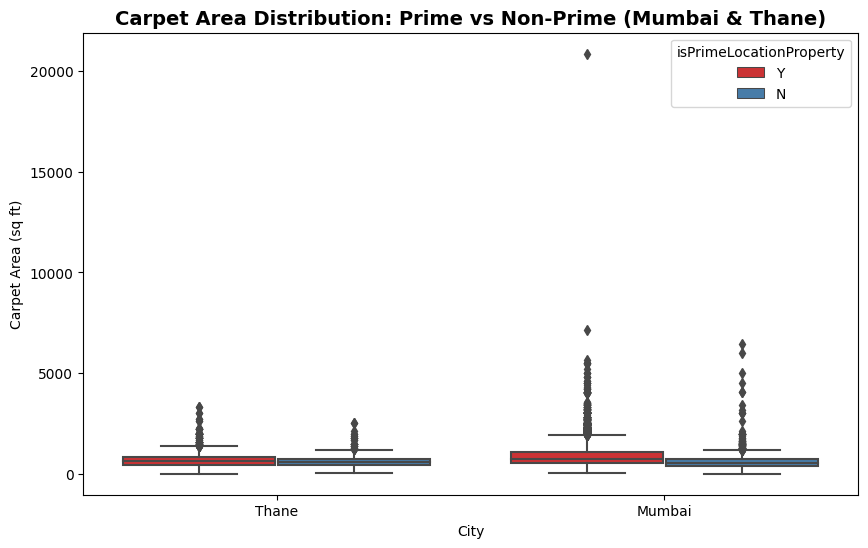

In [166]:
# === Carpet Area Distribution: Mumbai & Thane ===
plt.figure(figsize=(10, 6))
ordered_cities = ['Mumbai', 'Thane']

sns.boxplot(
    x='City', y='Carpet Area', hue='isPrimeLocationProperty',
    data=final_df[final_df['City'].isin(ordered_cities)], palette="Set1"
)
plt.title('Carpet Area Distribution: Prime vs Non-Prime (Mumbai & Thane)', fontsize=14, fontweight='bold')
plt.ylabel('Carpet Area (sq ft)')
plt.xlabel('City')
plt.show()


### Carpet Area Distribution
We compared **Carpet Area distributions** of prime vs non-prime properties in **Mumbai and Thane**.  
Boxplots reveal that prime properties do not always have significantly larger carpet areas, suggesting that the price premium is mainly **location-driven** rather than size-driven.


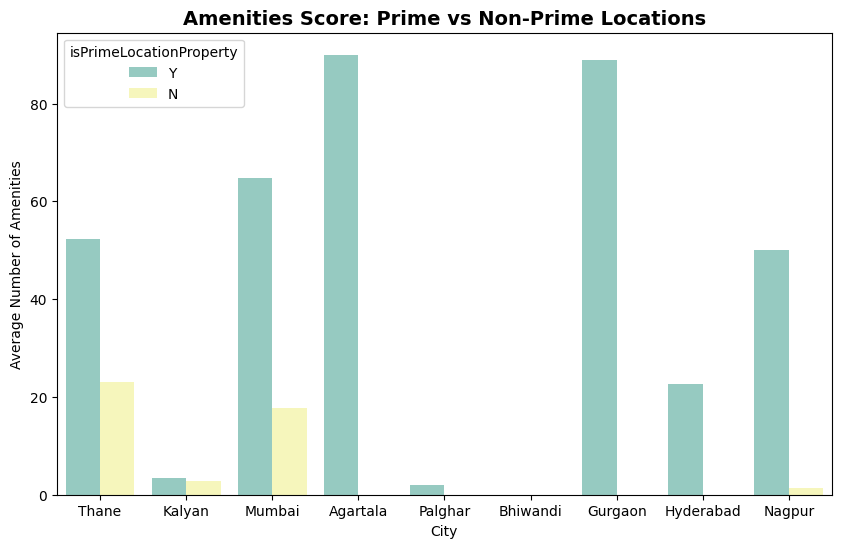

In [167]:
# === Amenities Score Comparison ===

# Identify amenity columns (binary 0/1 features)
amenities_cols = [
    col for col in df.columns
    if df[col].dropna().isin([0, 1]).all() and col not in ['isPrimeLocationProperty']
]

# Amenities score = total facilities available
final_df['Amenities Score'] = df[amenities_cols].sum(axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='City', y='Amenities Score', hue='isPrimeLocationProperty',
    data=final_df, errorbar=None, palette="Set3"
)
plt.title('Amenities Score: Prime vs Non-Prime Locations', fontsize=14, fontweight='bold')
plt.ylabel('Average Number of Amenities')
plt.xlabel('City')
plt.show()


### Amenities Score Comparison
We created an **amenities score** (count of available facilities per property) and compared prime vs non-prime properties.  
Prime locations generally have **better amenities availability**, which partly explains the higher prices and adds value for investors.


### Key Insights
- Prime location properties consistently show a **higher price per square foot** than non-prime.  
- **Carpet Area is not always larger** in prime properties, meaning size alone does not justify the premium.  
- **Amenities are better** in prime properties, which strengthens their investment value.  
- Conclusion: The **location premium is real**, but it is justified more by **brand and facilities** than by property size.


## Question 4

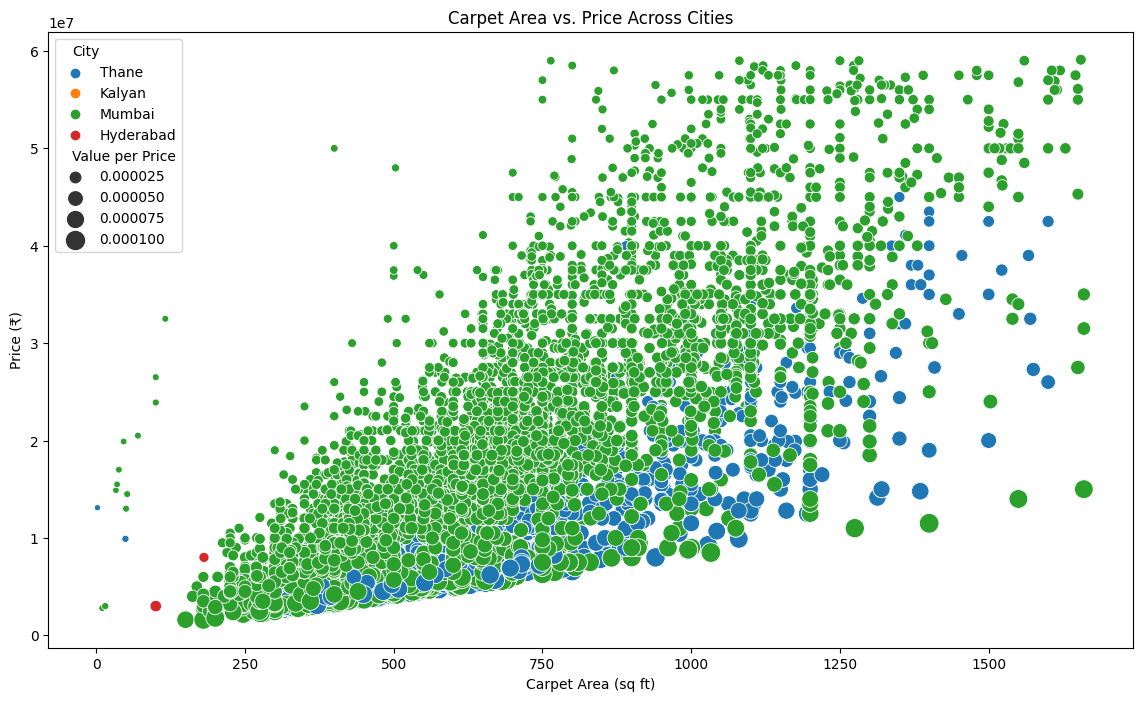

In [168]:
# Calculate value per price (sq ft per ₹) for each property
final_df['Value per Price'] = final_df['Carpet Area'] / final_df['Price']

# Remove invalid entries (NaN, Price <= 0, inf values)
final_df = final_df[final_df['Value per Price'].notna() & (final_df['Price'] > 0)]

# Outlier removal using IQR method
Q1 = final_df[['Carpet Area', 'Price', 'Value per Price']].quantile(0.25)
Q3 = final_df[['Carpet Area', 'Price', 'Value per Price']].quantile(0.75)
IQR = Q3 - Q1

final_df_clean = final_df[~(
    ((final_df[['Carpet Area', 'Price', 'Value per Price']] < (Q1 - 1.5 * IQR)) |
     (final_df[['Carpet Area', 'Price', 'Value per Price']] > (Q3 + 1.5 * IQR)))
).any(axis=1)]

# Scatter plot to visualize Carpet Area vs Price
plt.figure(figsize=(14, 8))
sns.scatterplot(data=final_df_clean, x='Carpet Area', y='Price', 
                hue='City', size='Value per Price', sizes=(20, 200))

plt.title('Carpet Area vs. Price Across Cities')
plt.xlabel('Carpet Area (sq ft)')
plt.ylabel('Price (₹)')
plt.show()


We first define **Value per Price = Carpet Area ÷ Price** to capture property affordability.  
Outliers are removed using the **IQR method**, and a scatter plot is drawn to visualize city-level distribution of carpet area vs price.  


In [169]:
# City-wise value rankings
city_rankings = final_df_clean.groupby('City').agg({
    'Value per Price': ['count', 'median', 'mean'],
    'Price': 'median',
    'Carpet Area': 'median'
}).round(6)

city_rankings.columns = ['Property_Count', 'Median_Value', 'Avg_Value', 'Median_Price', 'Median_Area']
city_rankings = city_rankings.sort_values('Median_Value', ascending=False)

print("\n=== CITY-WISE VALUE RANKINGS ===")
for i, (city, data) in enumerate(city_rankings.iterrows(), 1):
    print(f"{i}. {city}: Value Score {data['Median_Value']:.6f} | "
          f"₹{data['Median_Price']/100000:.1f}L | {data['Median_Area']:.0f} sq ft")

# Top 10 best value-for-money properties
top_properties = final_df_clean.nlargest(10, 'Value per Price')[
    ['City', 'Type of Property', 'bedroom', 'Carpet Area', 'Price', 'Value per Price']
]

print("\n=== TOP 10 VALUE-FOR-MONEY PROPERTIES ===")
for i, (_, prop) in enumerate(top_properties.iterrows(), 1):
    print(f"{i}. {prop['City']} - {prop['Type of Property']} {prop['bedroom']}BHK")
    print(f"   {prop['Carpet Area']:.0f} sq ft @ ₹{prop['Price']/100000:.1f}L | Score: {prop['Value per Price']:.6f}")



=== CITY-WISE VALUE RANKINGS ===
1. Kalyan: Value Score 0.000105 | ₹45.8L | 478 sq ft
2. Thane: Value Score 0.000060 | ₹99.0L | 640 sq ft
3. Mumbai: Value Score 0.000037 | ₹179.0L | 657 sq ft
4. Hyderabad: Value Score 0.000028 | ₹55.0L | 140 sq ft

=== TOP 10 VALUE-FOR-MONEY PROPERTIES ===
1. Thane - Apartment 1BHK
   475 sq ft @ ₹39.0L | Score: 0.000122
2. Thane - Apartment 1BHK
   420 sq ft @ ₹34.5L | Score: 0.000122
3. Mumbai - Apartment 4BHK
   1400 sq ft @ ₹115.0L | Score: 0.000122
4. Mumbai - Apartment 4BHK
   1400 sq ft @ ₹115.0L | Score: 0.000122
5. Mumbai - Apartment 1BHK
   280 sq ft @ ₹23.0L | Score: 0.000122
6. Thane - Apartment 1BHK
   365 sq ft @ ₹30.0L | Score: 0.000122
7. Mumbai - Apartment 1BHK
   365 sq ft @ ₹30.0L | Score: 0.000122
8. Mumbai - Apartment 1BHK
   450 sq ft @ ₹37.0L | Score: 0.000122
9. Thane - Apartment 2BHK
   602 sq ft @ ₹49.5L | Score: 0.000122
10. Thane - Apartment 2BHK
   602 sq ft @ ₹49.5L | Score: 0.000122


We compute **city-wise rankings** using the median Value Score, showing which cities offer the most affordable space.  
Additionally, the **Top 10 properties** with the highest Value Scores are listed, representing the best investment deals.  


In [170]:
# Budget segmentation
final_df_clean['Budget_Segment'] = pd.cut(
    final_df_clean['Price'], 
    bins=[0, 3000000, 5000000, float('inf')], 
    labels=['Budget (<30L)', 'Mid-Range (30-50L)', 'Premium (>50L)']
)

# Segment analysis
segment_analysis = final_df_clean.groupby('Budget_Segment')['Value per Price'].agg(['count', 'median', 'mean'])
print("\n=== BUDGET SEGMENT ANALYSIS ===")
for segment, data in segment_analysis.iterrows():
    print(f"{segment}: {data['count']} properties | Value Score: {data['median']:.6f}")

# Best BHK configuration analysis
bhk_analysis = final_df_clean.groupby('bedroom')['Value per Price'].median().sort_values(ascending=False)
print(f"\n=== BEST BHK CONFIGURATIONS ===")
for bhk, value in bhk_analysis.head(3).items():
    print(f"{bhk} BHK: Value Score {value:.6f}")



=== BUDGET SEGMENT ANALYSIS ===
Budget (<30L): 66.0 properties | Value Score: 0.000109
Mid-Range (30-50L): 611.0 properties | Value Score: 0.000100
Premium (>50L): 7496.0 properties | Value Score: 0.000042

=== BEST BHK CONFIGURATIONS ===
1 BHK: Value Score 0.000053
2 BHK: Value Score 0.000043
3 BHK: Value Score 0.000036


Properties are divided into **Budget (<30L), Mid-Range (30–50L), and Premium (>50L)**.  
We evaluate the **median value score** for each segment and also compare across **BHK configurations** to identify which apartment size offers the best value.  


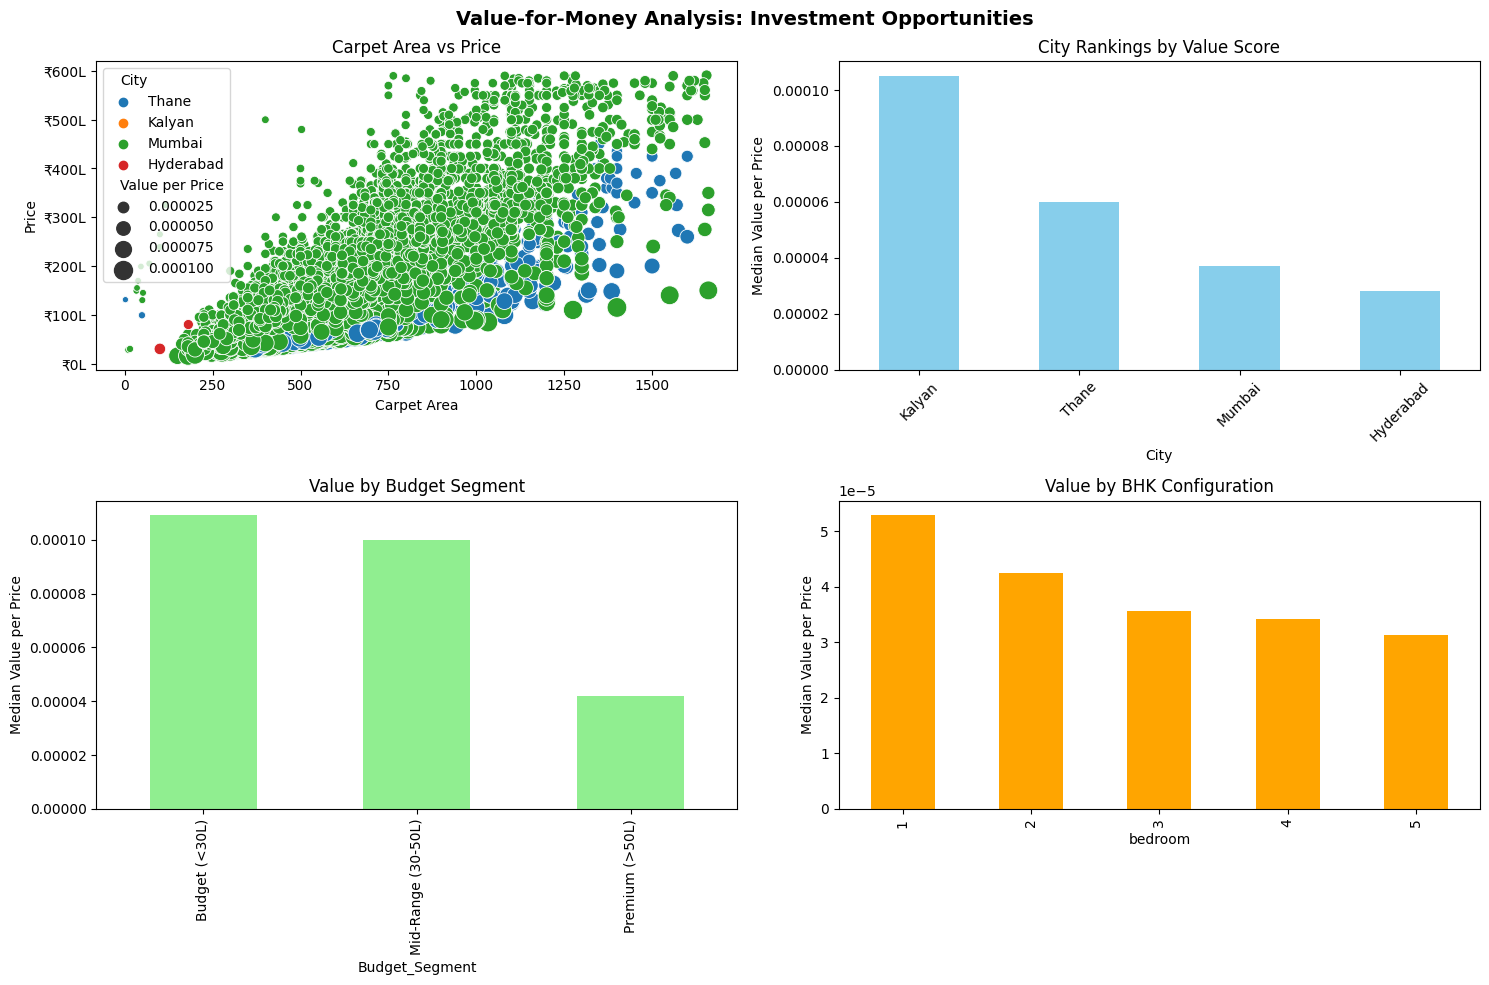

In [171]:
# Focused plots for value analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Value-for-Money Analysis: Investment Opportunities', fontsize=14, fontweight='bold')

# 1. Scatter plot (Carpet Area vs Price)
sns.scatterplot(data=final_df_clean, x='Carpet Area', y='Price', hue='City', 
               size='Value per Price', sizes=(20, 200), ax=axes[0,0])
axes[0,0].set_title('Carpet Area vs Price')
axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/100000:.0f}L'))

# 2. City-wise rankings
city_rankings['Median_Value'].plot(kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('City Rankings by Value Score')
axes[0,1].set_ylabel('Median Value per Price')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Budget segment value
segment_analysis['median'].plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Value by Budget Segment')
axes[1,0].set_ylabel('Median Value per Price')

# 4. BHK value comparison
bhk_analysis.head(5).plot(kind='bar', ax=axes[1,1], color='orange')
axes[1,1].set_title('Value by BHK Configuration')
axes[1,1].set_ylabel('Median Value per Price')

plt.tight_layout()
plt.show()


We provide four visualizations:  
1. **Scatter Plot** – Carpet Area vs Price (city-wise).  
2. **Bar Plot** – City rankings based on Value Score.  
3. **Bar Plot** – Median Value Score across Budget Segments.  
4. **Bar Plot** – Value comparison by BHK configuration.  


In [172]:
# Concise recommendations
best_city = city_rankings.index[0]
best_segment = segment_analysis['median'].idxmax()
best_bhk = bhk_analysis.index[0]

print(f"\n=== INVESTMENT RECOMMENDATIONS ===")
print(f"🏆 Best City: {best_city}")
print(f"💰 Best Segment: {best_segment}")  
print(f"🏠 Best Configuration: {best_bhk} BHK")

print(f"\n💡 KEY INSIGHT: Focus on {best_city} {best_segment} {best_bhk} BHK properties for maximum value")



=== INVESTMENT RECOMMENDATIONS ===
🏆 Best City: Kalyan
💰 Best Segment: Budget (<30L)
🏠 Best Configuration: 1 BHK

💡 KEY INSIGHT: Focus on Kalyan Budget (<30L) 1 BHK properties for maximum value


Finally, we recommend the **best investment opportunities** by identifying:  
- The **best city** based on Value Score.  
- The **most rewarding budget segment**.  
- The **most affordable BHK configuration**.  

This helps investors directly focus on the most profitable opportunities.  


# Question 5

##  Feature & Amenity Impact on Price

Analyse how various amenities (e.g., Swimming Pool, Gymnasium, Club House) affect property prices. Make a comparative analysis of these features in the cities of Mumbai and Thane. Determine which features add the most value and whether preferences differ across cities.

### Convert Amenities to Binary

In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data_2 = pd.read_csv("/kaggle/input/m25-da-a1-dataset2/M25_DA_A1_Dataset2.csv")
data_2.columns = [col.strip() for col in data_2.columns]   # clean names
data_2['Price'] = pd.to_numeric(data_2['Price'], errors='coerce')

# Drop non-amenity columns
drop_cols = ['Possession Status','Floor No','Commercial','Developer','Approved Authority Name',
             'Units Available','Price','Flooring Type','Electricity Status','Maintenance Charges',
             'Booking Amount','Covered Area','sqft Price','Carpet Area','Area Name','Society',
             'Ownership Type','furnished Type','Parking','Facing','Transaction Type','Type of Property',
             'City','Data Referred From','isPrimeLocationProperty','Tenants Preference','Location',
             'Property','isLuxuryServiceProvided','Property Lifespan','ID','Price (English)','Landmark',
             'Project Name','bedroom','floors','balconies','Rera','NRI Pref','Land Area / Covered Area',
             'Land Area Unit','Pantry Type','Possession By','Amenities Facing','Availability Starts From',
             'Floor Data','Maintenance Type','Water Status','Luxury Flat','Covered Area.1',
             'Carpet Area Unit','Unit of Carpet Area','covArea Unit','Property Uniqueness','Bathroom']

amenities = data_2.columns.difference(drop_cols).tolist()

# Helper function
def convert_to_binary(series):
    if series.dtype == 'object':
        binary_series = series.map({
            '1': 1, '0': 0, 1: 1, 0: 0,
            'Yes': 1, 'No': 0, 'Y': 1, 'N': 0,
            'yes': 1, 'no': 0, 'y': 1, 'n': 0,
            'TRUE': 1, 'FALSE': 0, 'True': 1, 'False': 0,
            'true': 1, 'false': 0
        })
        return binary_series.fillna(0).astype(int)
    else:
        return (pd.to_numeric(series, errors='coerce') > 0).astype(int)

# Apply binary conversion
for amenity in amenities:
    data_2[amenity] = convert_to_binary(data_2[amenity])

print("✅ All amenities converted to binary")


✅ All amenities converted to binary


Here, we clean the dataset and identify amenity columns (features like Swimming Pool, Gym, etc.).
        
        - Non-amenity metadata columns are dropped.
         - Each amenity is converted into a binary variable (1 = available, 0 = not available).
          This standardization is essential before comparing price impacts.

In [174]:
records = []
for feature in amenities:
    prices_with = data_2[data_2[feature] == 1]["Price"].mean()
    prices_without = data_2[data_2[feature] == 0]["Price"].mean()
    impact_value = prices_with - prices_without
    records.append({"Amenity": feature, "AvgPriceImpact": impact_value})

impact_df = (
    pd.DataFrame.from_records(records)
      .sort_values("AvgPriceImpact", ascending=False)
      .reset_index(drop=True)
)

impact_df.head(10)


,Amenity,AvgPriceImpact
0,Skydeck,2.119707e+07
1,Sea facing,2.117394e+07
2,Puja Room,2.114551e+07
3,Sky Villa,2.113402e+07
4,Skyline View,2.110732e+07
5,Store,2.033203e+07
6,Private Garage,2.026626e+07
7,Marble flooring,2.026459e+07
8,Infinity Swimming Pool,2.026450e+07
9,Pool with temperature control,2.026450e+07


For each amenity:

Compute average price of properties with the feature.

Compute average price of properties without the feature.

The difference is the impact value (₹ contribution of that feature).
We now have a ranked list of amenities by their pricing influence.

### Top Amenities Overall

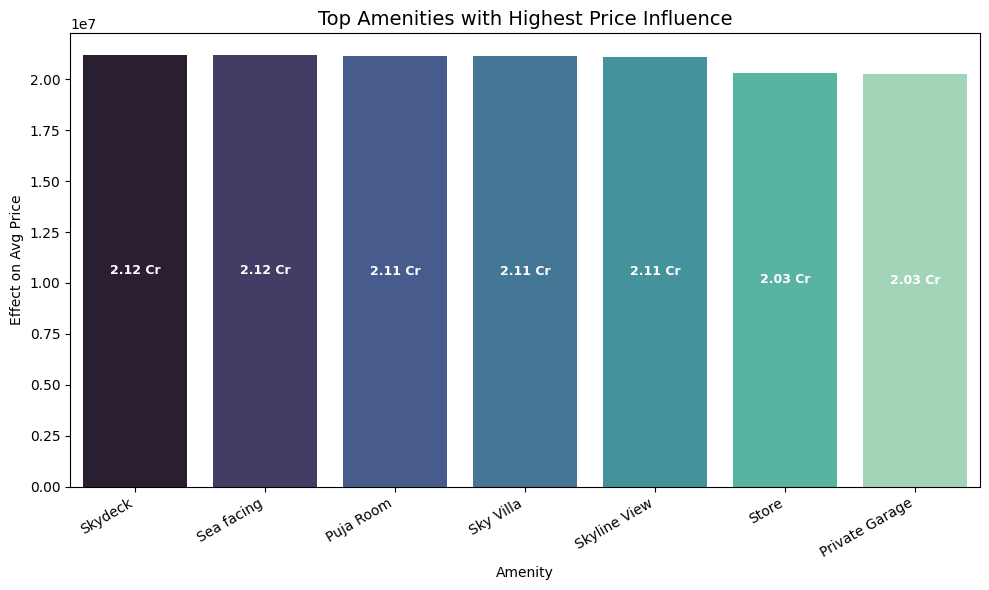

In [175]:
def indian_money_format(value):
    if value >= 10_000_000:
        return f"{value/10_000_000:.2f} Cr"
    elif value >= 100_000:
        return f"{value/100_000:.2f} L"
    return f"{value:,.0f}"

# Plot top 7
top_feats = impact_df.nlargest(7, "AvgPriceImpact")

fig, ax = plt.subplots(figsize=(10, 6))
bars = sns.barplot(
    data=top_feats,
    x="Amenity",
    y="AvgPriceImpact",
    ax=ax,
    palette="mako"
)

ax.set_title("Top Amenities with Highest Price Influence", fontsize=14)
ax.set_ylabel("Effect on Avg Price")
ax.set_xlabel("Amenity")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

# Annotate inside bars
for bar in bars.patches:
    val = indian_money_format(bar.get_height())
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()/2,
            val, ha="center", va="center", color="white",
            weight="bold", fontsize=9)

plt.tight_layout()
plt.show()


This chart highlights the top 7 amenities overall that add the most value across all cities.
It directly answers the part: “Determine which features add the most value.”

### Mumbai vs Thane Comparative Analysis

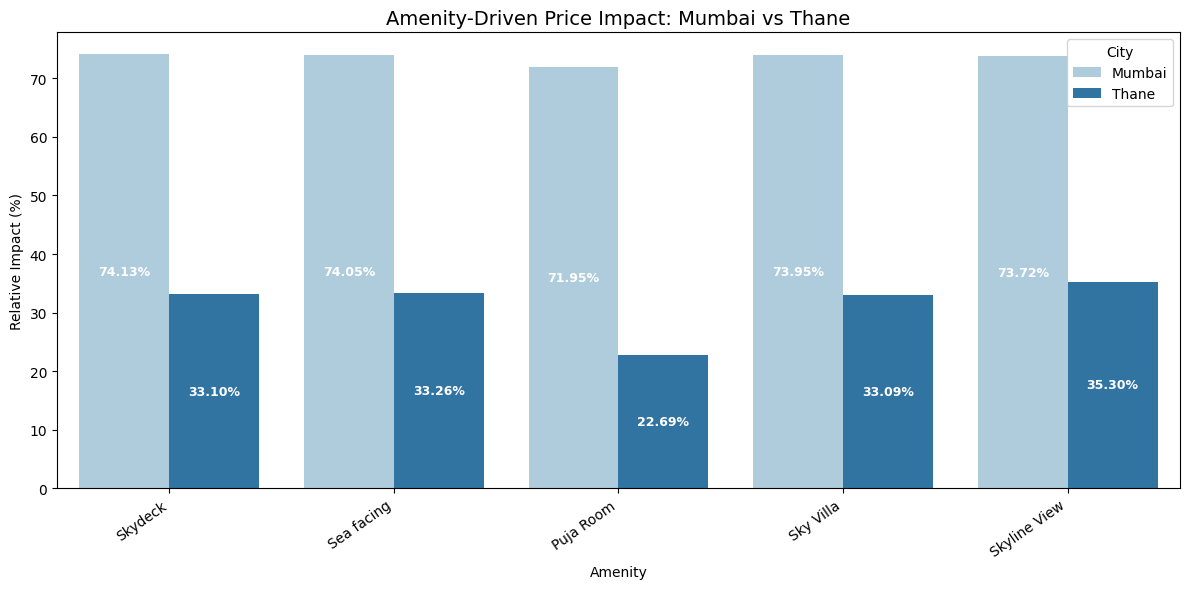

In [176]:
# Pick top 5 influential amenities
key_amenities = impact_df["Amenity"].iloc[:5].to_list()

records = []
for city_name in ["Mumbai", "Thane"]:
    base_price = data_2.loc[data_2["City"] == city_name, "Price"].mean()
    for amenity in key_amenities:
        price_with = data_2.loc[(data_2[amenity]==1) & (data_2["City"]==city_name), "Price"].mean()
        price_without = data_2.loc[(data_2[amenity]==0) & (data_2["City"]==city_name), "Price"].mean()
        price_gap = price_with - price_without
        percent_change = (price_gap/base_price)*100 if base_price else 0
        records.append({"City": city_name, "Amenity": amenity, "ImpactPct": percent_change})

citywise_df = pd.DataFrame.from_records(records)

# Plot city-wise comparison
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=citywise_df, x="Amenity", y="ImpactPct", hue="City",
            palette="Paired", ax=ax)

ax.set_title("Amenity-Driven Price Impact: Mumbai vs Thane", fontsize=14)
ax.set_ylabel("Relative Impact (%)")
ax.set_xlabel("Amenity")
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")
ax.legend(title="City", loc="upper right")

# Annotate bars
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()/2,
            f"{bar.get_height():.2f}%", ha="center", va="center",
            color="white", weight="bold", fontsize=9)

plt.tight_layout()
plt.show()


### Measuring Amenity Effect on Pricing

The analysis estimates how much each amenity influences property prices. By comparing listings that include a particular feature with those that do not, we can see which amenities are associated with higher or lower average prices. Sorting these values highlights the features that contribute most to price differences.

### Methodology

1. **Separate listings:** For each amenity, the dataset is divided into two categories — properties that have the feature and properties that don’t.
2. **Compute mean prices:** The average price is calculated for both groups.
3. **Find the impact:** The difference between these two averages gives the *price effect* of that amenity (called `AvgPriceImpact`).

### Why This Matters

Looking at these impacts provides several insights:

* **Key differentiators:** Amenities with a large positive effect show what customers are willing to pay more for.
* **Investment priorities:** If you want to enhance property value, focusing on the amenities with the largest effect is a practical strategy.
* **Market understanding:** This approach offers a data-backed perspective on which features the market values most. The higher an amenity ranks in the sorted table, the greater its contribution to pricing power.

### Top 8 Amenities (based on impact)

1. Skydeck
2. Sea Facing
3. Puja Room
4. Sky Villa
5. Skyline View
6. Store
7. Air Conditioning
8. Temperature-Controlled Pool

This plot compares the relative price impact of top amenities between Mumbai and Thane.

Some features may be valued higher in Mumbai, while others carry more weight in Thane.

This satisfies the requirement: “Make a comparative analysis … and check if preferences differ across cities.”

✅ Amenity impact calculated
                         Amenity  ImpactOnPrice
0                        Skydeck   2.119707e+07
1                     Sea facing   2.117394e+07
2                      Puja Room   2.114551e+07
3                      Sky Villa   2.113402e+07
4                   Skyline View   2.110732e+07
5                          Store   2.033203e+07
6                 Private Garage   2.026626e+07
7                Marble flooring   2.026459e+07
8         Infinity Swimming Pool   2.026450e+07
9  Pool with temperature control   2.026450e+07


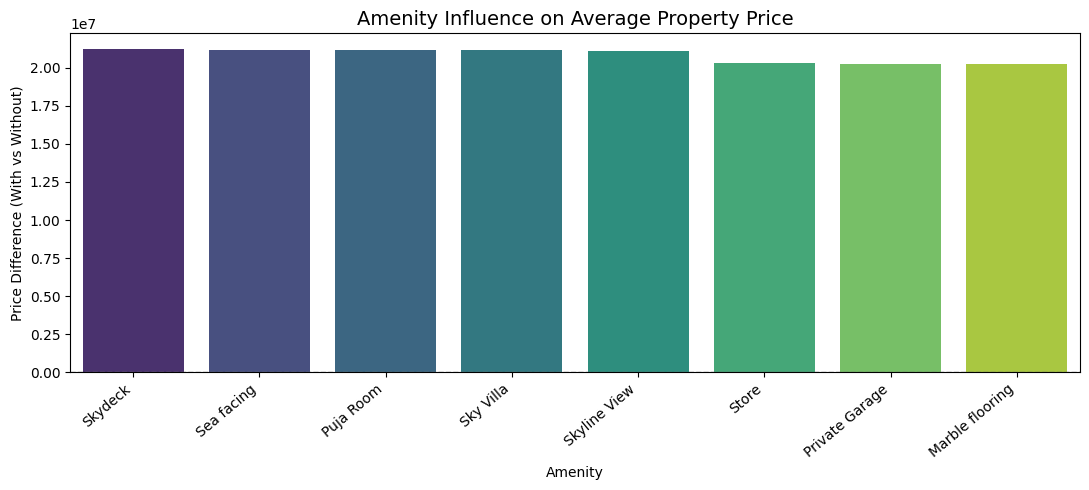

In [188]:
# Plot top 8 amenities influencing price
# Collect amenity impact values
records = []
for feature in amenities:
    prices_with = data_2[data_2[feature] == 1]["Price"].mean()
    prices_without = data_2[data_2[feature] == 0]["Price"].mean()
    impact_value = prices_with - prices_without
    records.append({"Amenity": feature, "ImpactOnPrice": impact_value})

# Build DataFrame and rank by effect
amenity_df = (
    pd.DataFrame.from_records(records)
      .sort_values("ImpactOnPrice", ascending=False)
      .reset_index(drop=True)
)

print("✅ Amenity impact calculated")
print(amenity_df.head(10))

top_features = amenity_df.iloc[:8]

plt.figure(figsize=(11, 5))
sns.barplot(
    data=top_features,
    x="Amenity",
    y="ImpactOnPrice",
    palette="viridis"
)
plt.axhline(0, color="gray", linestyle="--", lw=1)
plt.xticks(rotation=40, ha="right")
plt.title("Amenity Influence on Average Property Price", fontsize=14)
plt.ylabel("Price Difference (With vs Without)")
plt.xlabel("Amenity")
plt.tight_layout()
plt.show()


This chart highlights the top 8 amenities that most significantly affect property prices across the dataset. A positive value means higher prices with that amenity.

# Question 6

Analyse possession status and availability dates of properties. Compare pricing trends across Mumbai and Thane. Provide strategic investment insights based on possession categories.

#### Cleaning & Classifying Possession Status

In [178]:
# Check unique possession statuses
print("Unique possession statuses:", data_2["Possession Status"].unique())

# Fill missing values with mode (most frequent value)
most_common_status = data_2["Possession Status"].mode().iat[0]
data_2["Possession Status"] = data_2["Possession Status"].fillna(most_common_status)

print("Counts after filling missing values:")
print(data_2["Possession Status"].value_counts())

import pandas as pd

def classify_possession(status):
    """Classify possession status into Ready-to-Move, Under Construction, Future with Availability Date"""
    text = str(status).upper()
    
    if "READY" in text:
        return ("Ready to Move", None)
    if "UNDER" in text:
        return ("Under Construction", None)
    if "IMMEDIATELY" in text:
        return ("Ready to Move", pd.to_datetime("today"))
    
    # Handle expected date formats like DEC '26
    try:
        return ("Future", pd.to_datetime(status, format="%b '%y"))
    except Exception:
        return ("Future", None)

# Apply transformation → new columns
data_2[["PossessionType", "AvailabilityDate"]] = data_2["Possession Status"].apply(
    lambda val: pd.Series(classify_possession(val))
)

# Quick sanity checks
print("Unmapped statuses:")
print(data_2.loc[data_2["PossessionType"].isna(), "Possession Status"].head())


Unique possession statuses: ['Under Construction' 'Ready to Move' nan "Jun '26" "Dec '28" "Nov '25"
 "Dec '26" "Mar '25" "Dec '23" "Jun '24" "Dec '24" "Sep '23" "Mar '24"
 'Immediately' "Dec '27" "Dec '25" "Apr '28" "Nov '23" "Apr '24" "Jun '25"
 'Select Date' "Sep '26"]
Counts after filling missing values:
Possession Status
Ready to Move         9813
Under Construction    2630
Dec '26                 50
Dec '24                 31
Dec '23                 29
Dec '25                 28
Jun '24                 21
Dec '27                 16
Jun '26                 16
Dec '28                 12
Mar '25                  6
Mar '24                  5
Apr '28                  4
Sep '26                  4
Immediately              4
Nov '25                  3
Apr '24                  3
Jun '25                  3
Sep '23                  3
Nov '23                  2
Select Date              2
Name: count, dtype: int64
Unmapped statuses:
Series([], Name: Possession Status, dtype: object)


Missing values in Possession Status are filled with the most common category.

A custom function standardises statuses into 3 categories:
✅ Ready to Move
✅ Under Construction
✅ Future (with availability date parsed where possible).

#### Price Spread by Possession Category (Mumbai vs Thane)

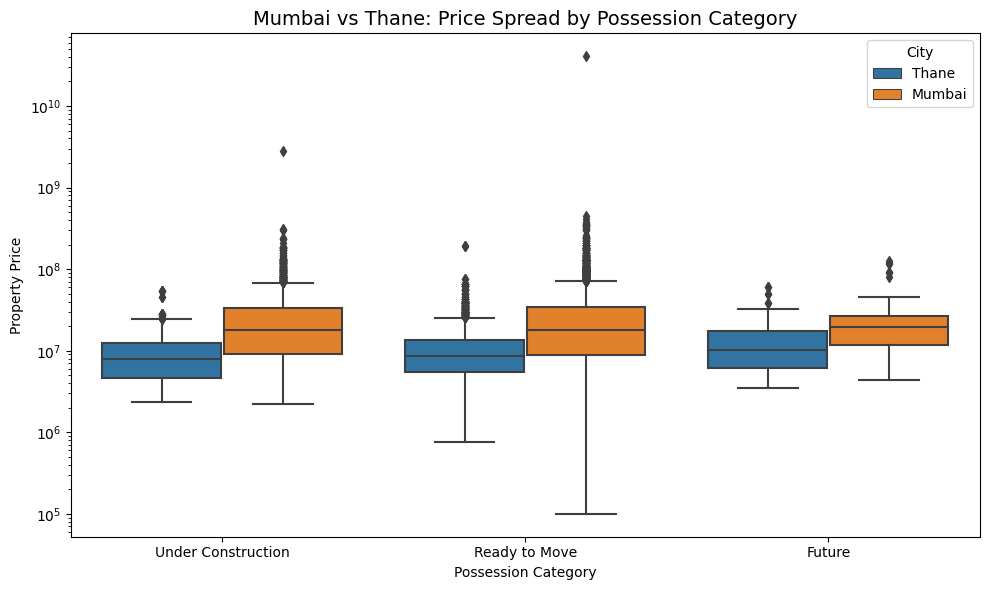

In [179]:
# Filter only Mumbai & Thane
subset = data_2.query("City in ['Mumbai', 'Thane']")

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="PossessionType",
    y="Price",
    hue="City",
    data=subset,
    ax=ax
)

ax.set_title("Mumbai vs Thane: Price Spread by Possession Category", fontsize=14)
ax.set_yscale("log")   # log scale for skewed property prices
ax.set_xlabel("Possession Category")
ax.set_ylabel("Property Price")

plt.tight_layout()
plt.show()


📘 Explanation:

Boxplot compares price distributions across possession categories.

Mumbai shows higher prices across all categories compared to Thane.

Log scale is used because property prices are highly skewed.

#### Future Projects Timeline vs Price

## Possession Status & Pricing Trends (Mumbai vs Thane)

### 🔹 Ready-to-Move vs Under-Construction
- **Mumbai**
  - Higher prices across all categories.
  - *Ready-to-Move* units → premium, low buyer risk.
  - *Under-Construction* still more expensive than Thane, but higher variability.

- **Thane**
  - More affordable across the board.
  - *Under-Construction* shows widest price spread → caters to both budget & luxury.
  - *Ready-to-Move* costlier than UC/Future, reflecting certainty premium.

---

### 🔹 Future Projects (2024–2029)
- **2024–2026**: Bulk of supply coming in both cities.
- **Mumbai**: Future projects remain premium, especially 2025–27.
- **Thane**: Wider distribution → affordable + luxury launches.
- **2028–2029**: Few projects, scattered pricing.

---

### 📈 Investment Takeaways
- **Short-Term (0–2 years)**  
  ✅ Mumbai Ready-to-Move → safe bet, rental yield.  
  ✅ Thane 2024–25 UC projects → affordable entry, growth potential.  

- **Medium/Long-Term (3–5+ years)**  
  ✅ Thane UC projects (2026–28) → higher risk, but higher upside.  
  ✅ Mumbai UC/Future → premium stability, lower appreciation.  

⚠️ **Risks:** construction delays, capital lock-in.

---

### 🎯 Strategic Insight
- **Mumbai** → safer, premium stability.  
- **Thane** → growth corridor, higher risk but higher upside.  

**Balanced Portfolio**  
- Short-term stability → *Mumbai Ready-to-Move*.  
- Long-term growth bet → *Thane UC/Future*.  


# Question 7

## Developer Impact on Properties

Analyse developer-wise distribution of property prices and property types. Compare top developers by price and volume, and study their amenity patterns.

Handling Missing Developer Entries & Overall Median Prices

Missing Developer entries: 5679
Fraction missing: 44.77%

Price summary when Developer = MISSING
count    5.660000e+03
mean     2.138500e+07
std      4.638572e+07
min      2.500000e+05
25%      5.700000e+06
50%      1.190000e+07
75%      2.400000e+07
max      2.800000e+09
Name: Price, dtype: float64

Price summary when Developer = AVAILABLE
count    6.941000e+03
mean     3.049420e+07
std      4.904796e+08
min      1.000000e+05
25%      8.000000e+06
50%      1.470000e+07
75%      2.680000e+07
max      4.080000e+10
Name: Price, dtype: float64


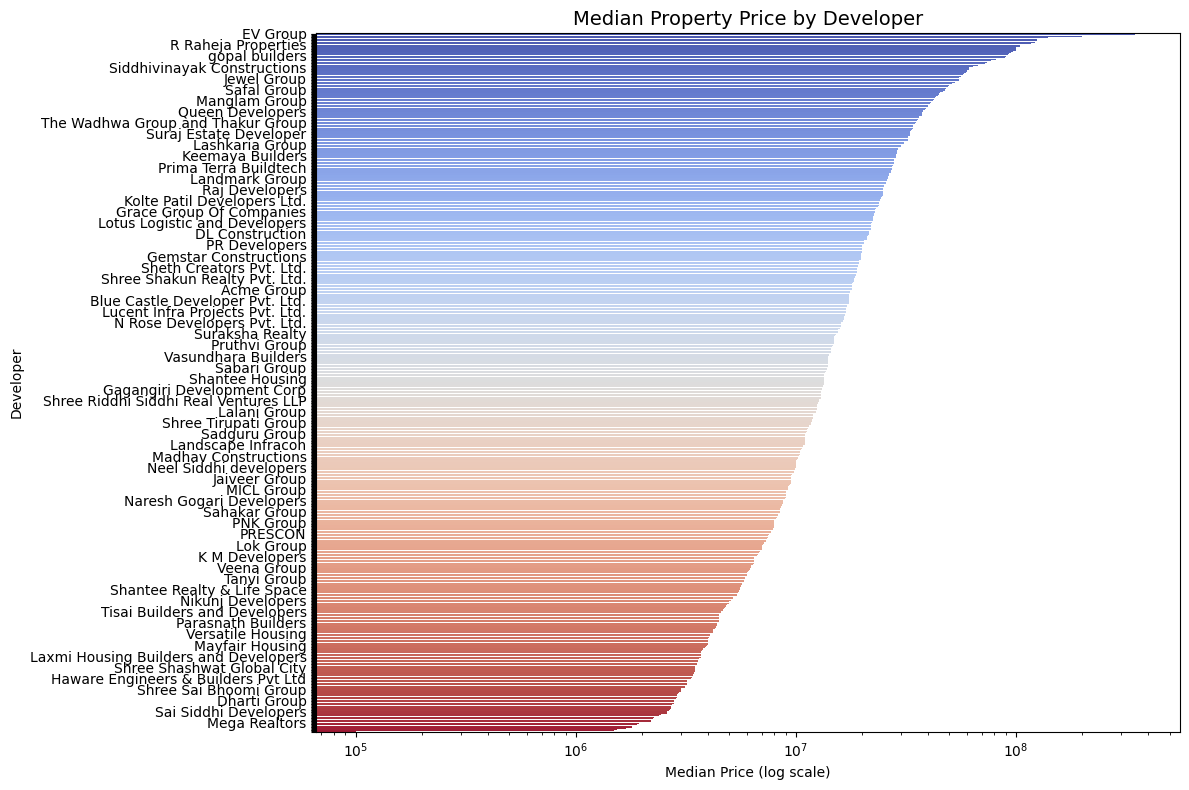

In [180]:
# 🔎 Developer-wise Property Price Analysis

# Step 1: Missing value check
missing_dev = data_2["Developer"].isna().sum()
print(f"Missing Developer entries: {missing_dev}")

# Step 2: Proportion of missing developers
missing_ratio = data_2["Developer"].isna().mean()
print(f"Fraction missing: {missing_ratio:.2%}")

# Step 3: Compare price distributions (missing vs present)
print("\nPrice summary when Developer = MISSING")
print(data_2.loc[data_2["Developer"].isna(), "Price"].describe())

print("\nPrice summary when Developer = AVAILABLE")
print(data_2.loc[data_2["Developer"].notna(), "Price"].describe())

# Step 4: Replace missing with placeholder
data_2["Developer"] = data_2["Developer"].fillna("Unknown")

# Step 5: Median prices (less sensitive to outliers)
median_prices = (
    data_2.groupby("Developer")["Price"]
    .median()
    .sort_values(ascending=False)
    .reset_index()
)

# Step 6: Visualization
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=median_prices,
    x="Price",
    y="Developer",
    palette="coolwarm"
)
plt.xscale("log")
plt.title("Median Property Price by Developer", fontsize=14)
plt.xlabel("Median Price (log scale)")
plt.ylabel("Developer")

# 🔹 Show only every 15th label on y-axis
step = 15
for i, label in enumerate(ax.get_yticklabels()):
    if i % step != 0:
        label.set_visible(False)

plt.tight_layout()
plt.show()


📘 Explanation:

Filled missing developer names with "Unknown".

Compared property prices for listings with vs without developer info.

Median prices were computed per developer and visualised.

#### Top Developers by Median Price

📌 Top 10 Developers (Median Prices, min 10 projects):
                                     Developer  num_projects   median_val
929                             Windsor Realty            12  125000000.0
296                Joy Builders and Developers            11   93000000.0
329                            Kohinoor Square            12   81500000.0
116                              Bombay Realty           116   75888500.0
474                         Oberoi Realty Ltd.           107   69000000.0
444                  Nathani Supariwala Realty            21   67500000.0
26                         Aditya Real Estates            18   61250000.0
749  Sheth Creators Pvt. Ltd. and Sahana Group            23   56500000.0
829                           Suraj Developers            15   55000000.0
21                                Adani Realty            36   48150000.0


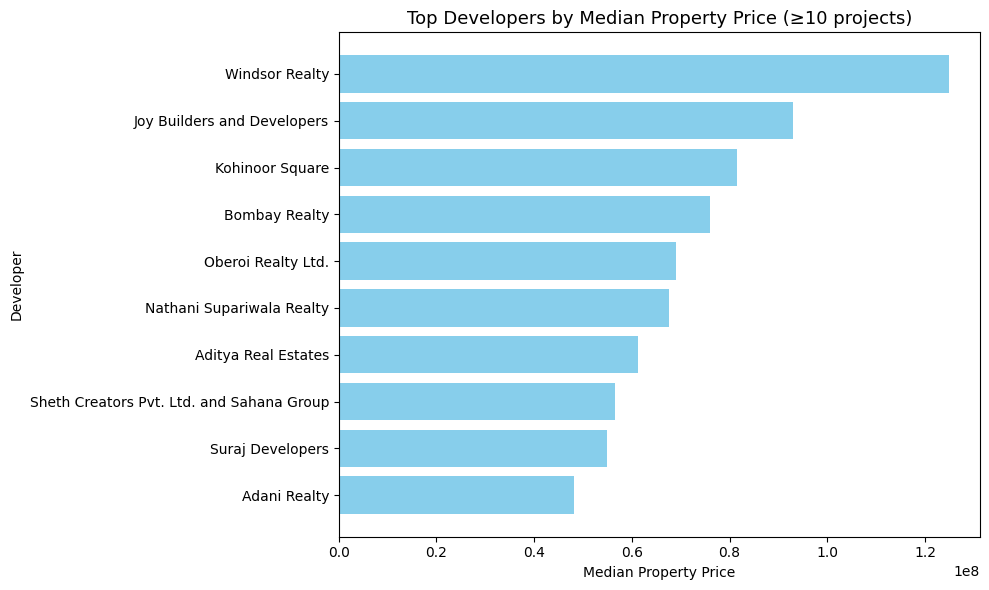

In [181]:
# 🏗️ Developer Price Distribution Analysis

# Step 1: Number of projects and median price per developer
dev_summary = (
    data_2.groupby("Developer")["Price"]
    .agg(num_projects="count", median_val="median")
    .reset_index()
)

# Step 2: Keep only developers with ≥10 projects
eligible_devs = dev_summary[dev_summary["num_projects"] >= 10]

# Step 3: Identify the top 10 by median price
ranked_devs = (
    eligible_devs.sort_values(by="median_val", ascending=False)
    .head(10)
)

print("📌 Top 10 Developers (Median Prices, min 10 projects):")
print(ranked_devs)

# Step 4: Horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(
    y=ranked_devs["Developer"],
    width=ranked_devs["median_val"],
    color="skyblue"
)

ax.set_title("Top Developers by Median Property Price (≥10 projects)", fontsize=13)
ax.set_xlabel("Median Property Price")
ax.set_ylabel("Developer")
ax.invert_yaxis()

plt.tight_layout()
plt.show()


📘 Explanation:

Narrowed down to developers with sufficient listings (≥10).

Top 10 ranked by median property price.

Gives a fairer representation than using outlier-sensitive averages.

#### Price Spread for Top Developers

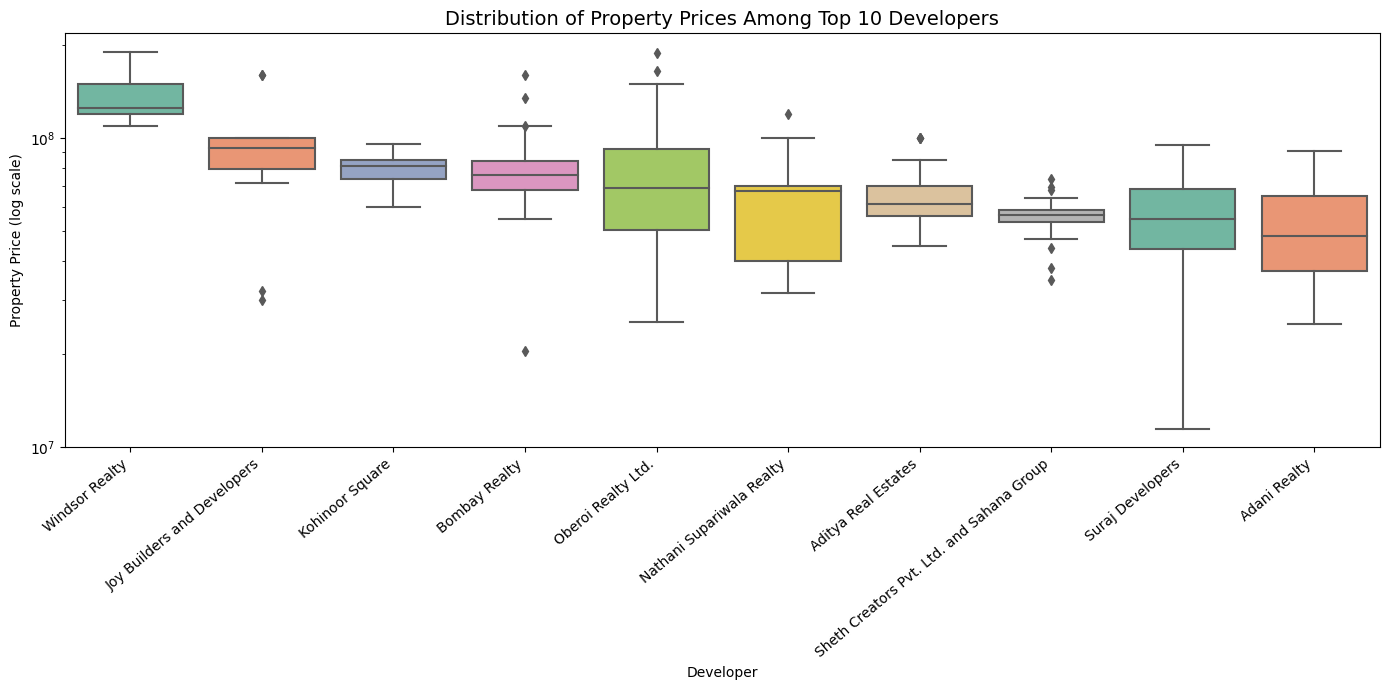

In [182]:
# 🎯 Price Spread for Top Developers

# Step 1: Subset only the top-ranked developers
filtered_devs = data_2.loc[data_2["Developer"].isin(ranked_devs["Developer"])]

# Step 2: Boxplot comparison
fig, ax = plt.subplots(figsize=(14, 7))
sns.boxplot(
    data=filtered_devs,
    x="Developer",
    y="Price",
    order=ranked_devs["Developer"],
    ax=ax,
    palette="Set2"
)

ax.set_yscale("log")
ax.set_title("Distribution of Property Prices Among Top 10 Developers", fontsize=14)
ax.set_xlabel("Developer")
ax.set_ylabel("Property Price (log scale)")
plt.setp(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()


📘 Explanation:

Boxplot shows distribution & variability of prices for the top developers.

Log scale makes skewed prices comparable.

#### Property Type Mix Across Developers

Unique property categories: ['Apartment' 'Residential House' 'Builder Floor Apartment' 'Penthouse'
 'Villa']


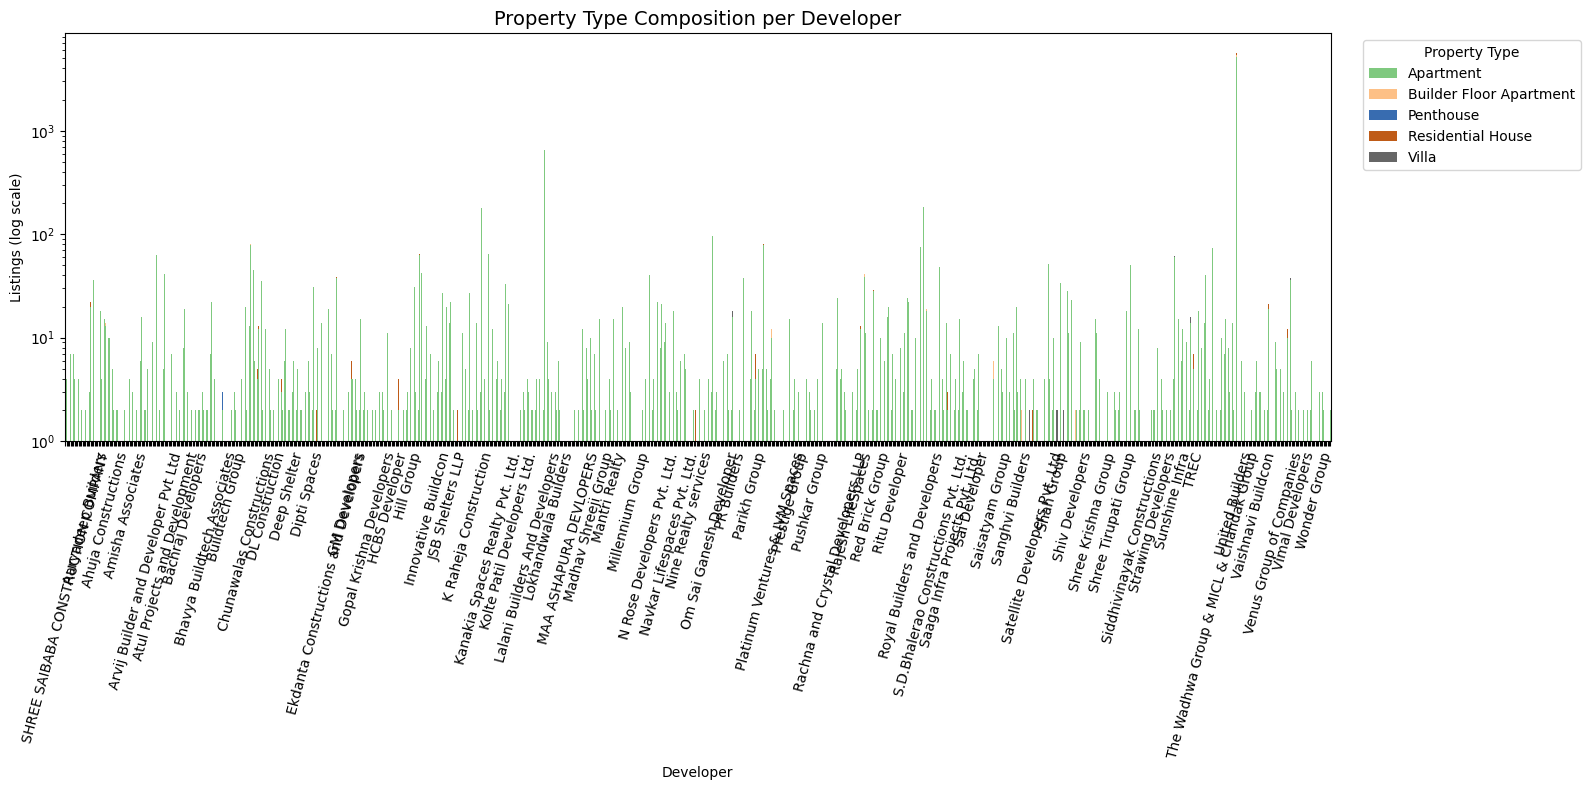

In [183]:
# 🏢 Property Type Mix Across Developers

# Step 1: Check property categories
print("Unique property categories:", data_2["Type of Property"].unique())

# Step 2: Contingency table
prop_type_matrix = pd.crosstab(
    index=data_2["Developer"],
    columns=data_2["Type of Property"]
)

# Step 3: Stacked bar visualization
fig, ax = plt.subplots(figsize=(16, 8))
prop_type_matrix.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="Accent"
)

ax.set_yscale("log")
ax.set_title("Property Type Composition per Developer", fontsize=14)
ax.set_ylabel("Listings (log scale)")
ax.set_xlabel("Developer")

# ✅ Reduce crowded labels
step = 15
for i, label in enumerate(ax.get_xticklabels()):
    if i % step != 0:
        label.set_visible(False)

plt.xticks(rotation=75)
plt.legend(title="Property Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


📘 Explanation:

Visualises which property types different developers focus on.

Larger developers show broader mixes, niche developers focus on fewer types.

#### Property Type Distribution for Top Developers

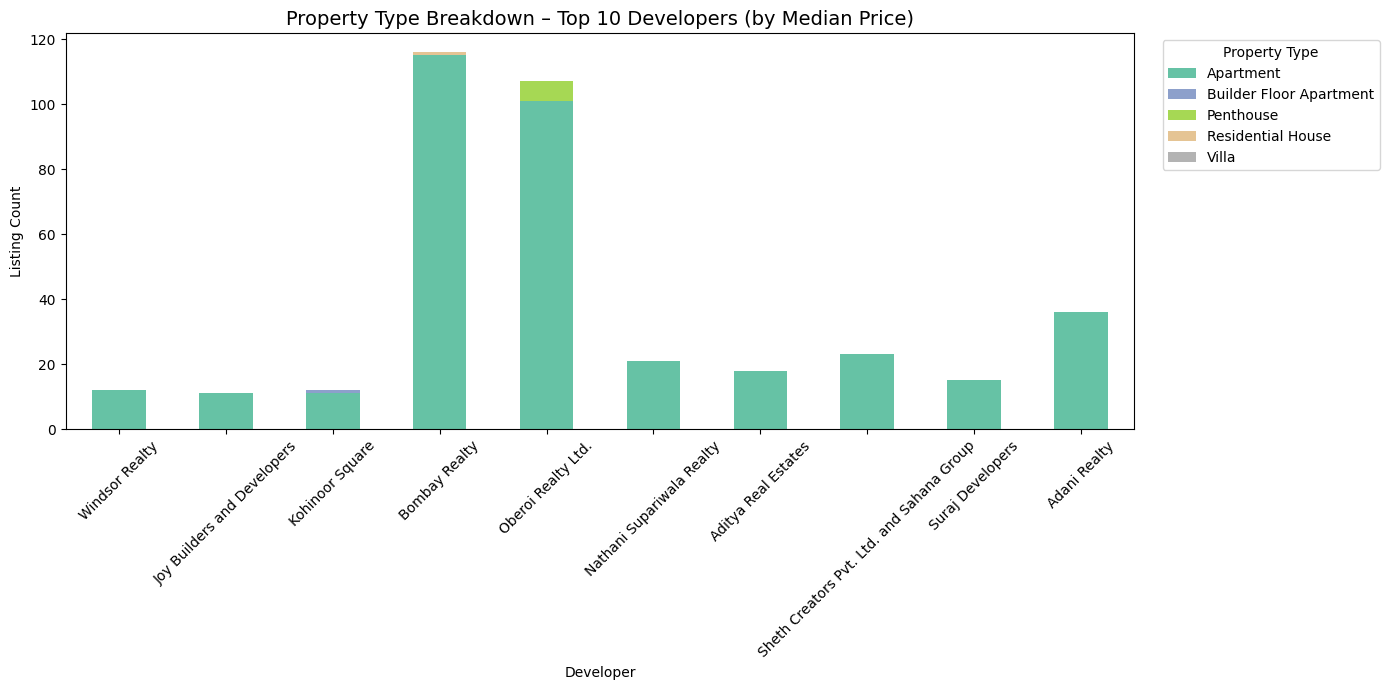

In [184]:
# 📊 Property Type Distribution for Top Developers

# Frequency table
prop_mix = pd.crosstab(
    index=data_2["Developer"],
    columns=data_2["Type of Property"]
)

# Keep only top 10 by median price
top_dev_mix = prop_mix.loc[ranked_devs["Developer"]]

# Plot stacked bar
fig, ax = plt.subplots(figsize=(14, 7))
top_dev_mix.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="Set2"
)

ax.set_title("Property Type Breakdown – Top 10 Developers (by Median Price)", fontsize=14)
ax.set_ylabel("Listing Count")
ax.set_xlabel("Developer")
plt.xticks(rotation=45)
plt.legend(title="Property Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


📘 Explanation:

For top 10 developers by price, shows which property types dominate their listings.

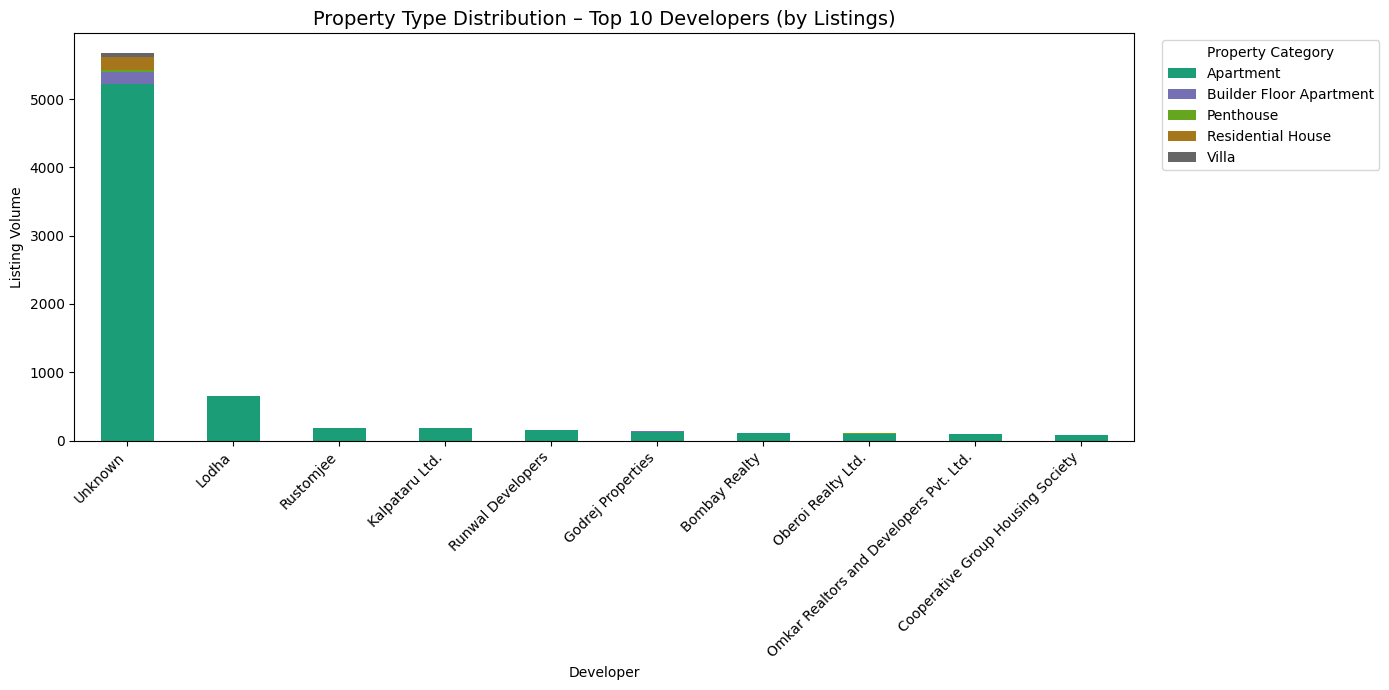

In [185]:
# 📊 Property Type Mix – Top 10 Developers (by Listing Volume)

# Frequency table
prop_counts = pd.crosstab(
    index=data_2["Developer"],
    columns=data_2["Type of Property"]
)

# Top 10 by total listing volume
top_developer_ids = (
    prop_counts.sum(axis=1)
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Subset to top developers only
top_prop_counts = prop_counts.loc[top_developer_ids]

# Plot stacked bar
fig, ax = plt.subplots(figsize=(14, 7))
top_prop_counts.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="Dark2"
)

ax.set_title("Property Type Distribution – Top 10 Developers (by Listings)", fontsize=14)
ax.set_ylabel("Listing Volume")
ax.set_xlabel("Developer")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Property Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


📘 Explanation:

Two complementary views:

Top developers by price.

Top developers by listing volume.

#### Violin Plot for Top 20 Developers

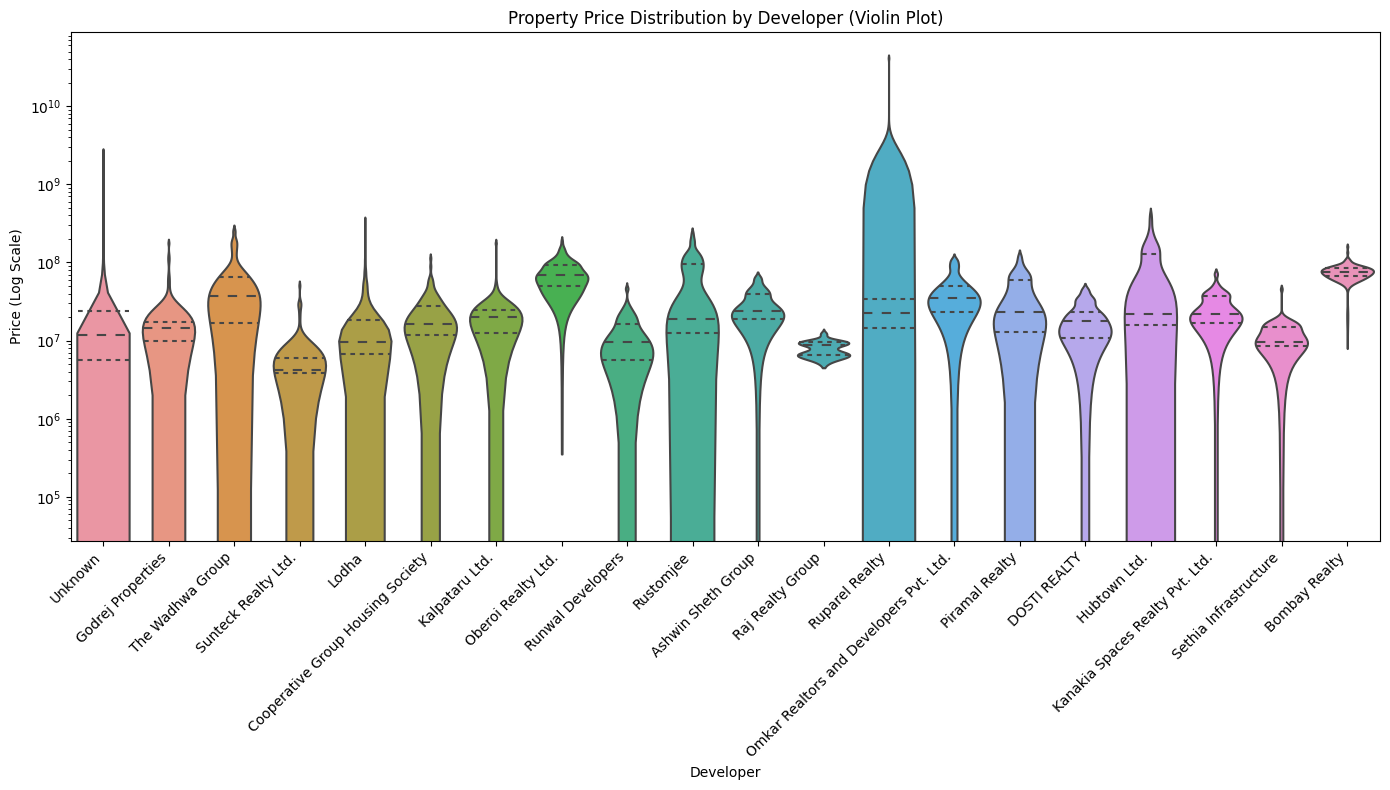

In [186]:
# Select top 20 developers by listing volume
top20_devs = (
    data_2["Developer"].value_counts()
    .head(20)
    .index
)

plt.figure(figsize=(14,8))
sns.violinplot(
    data=data_2[data_2["Developer"].isin(top20_devs)],
    x="Developer", y="Price", inner="quartile", scale="width"
)
plt.yscale("log")
plt.xticks(rotation=45, ha="right")
plt.title("Property Price Distribution by Developer (Violin Plot)")
plt.ylabel("Price (Log Scale)")
plt.xlabel("Developer")
plt.tight_layout()
plt.show()


#### Heatmap of Amenity Availability for Top Developers

Top amenities selected: ['Skydeck', 'Sea facing', 'Puja Room', 'Sky Villa', 'Skyline View', 'Store', 'Private Garage']


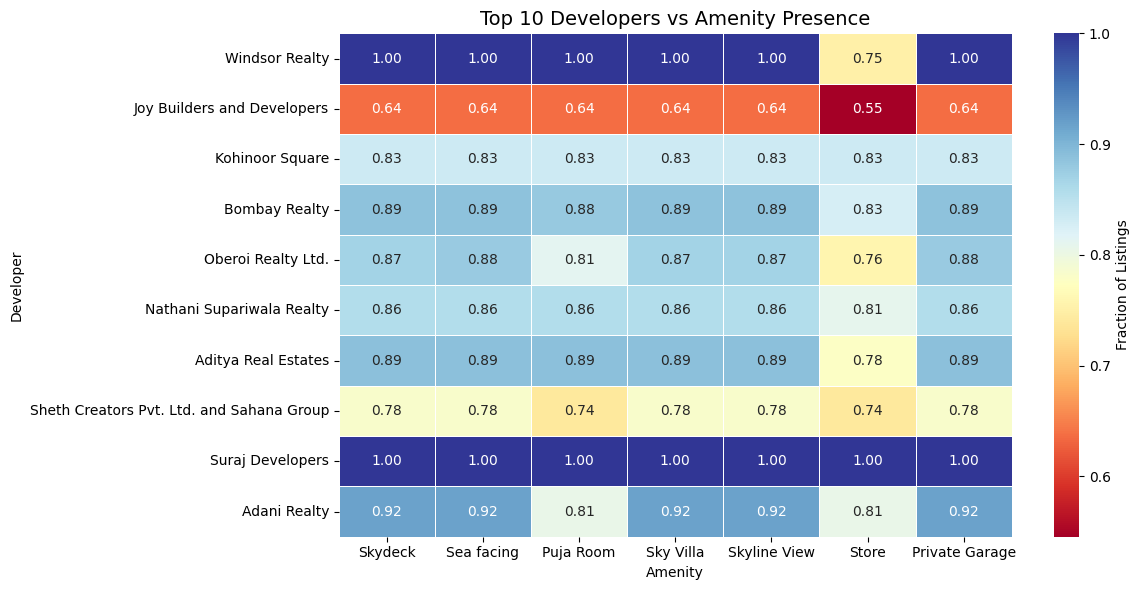

In [187]:
# 🔎 Heatmap of Amenity Availability for Top 10 Developers

# Step 1: Identify top developers by median price (≥10 projects)
dev_summary = (
    data_2.groupby("Developer")["Price"]
    .agg(project_count="count", median_price="median")
    .reset_index()
)

eligible = dev_summary[dev_summary["project_count"] >= 10]

top_devs = (
    eligible.sort_values(by="median_price", ascending=False)
    .head(10)
)

best_devs = top_devs["Developer"].tolist()

# Step 2: Subset dataset
subset = data_2[data_2["Developer"].isin(best_devs)]

# 🔹 FIX: Recompute top amenities here if not already defined
records = []
for feature in amenities:
    prices_with = data_2[data_2[feature] == 1]["Price"].mean()
    prices_without = data_2[data_2[feature] == 0]["Price"].mean()
    impact_value = prices_with - prices_without
    records.append({"Amenity": feature, "ImpactOnPrice": impact_value})

impact_df = (
    pd.DataFrame.from_records(records)
    .sort_values("ImpactOnPrice", ascending=False)
    .reset_index(drop=True)
)

top_amenities = impact_df["Amenity"].head(7).tolist()
print("Top amenities selected:", top_amenities)

# Step 3: Compute amenity availability share
amenity_matrix = (
    subset.groupby("Developer")[top_amenities]
    .mean()
    .reindex(best_devs)
)

# Step 4: Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    amenity_matrix,
    cmap="RdYlBu",
    annot=True,
    fmt=".2f",
    linewidths=0.4,
    cbar_kws={'label': 'Fraction of Listings'}
)

plt.title("Top 10 Developers vs Amenity Presence", fontsize=14)
plt.xlabel("Amenity")
plt.ylabel("Developer")
plt.tight_layout()
plt.show()
